# Brain Tumor Segmentation and Classification

# Introduction
Link to the presentation: https://docs.google.com/presentation/d/1jfu4_iKNSq1J96fCWlkjX1y9VZcb1AXIcZTELt2HK4c/edit?usp=sharing

Dataset link: https://figshare.com/articles/dataset/brain_tumor_dataset/1512427?file=7953679

As part of the final project for the AI 2 we have done project on Brain tumor segmentation and classification from the Brain MRI scan images. Since, accurate segmentation and classification is important for prognosis and treatment planning, this will be a help in the medical field. So our team: Abjasree S, Poojan Smart, Niranjan Solanki and Vaishnav Panuganti started working on segmenting the tumor and classifying it based on the methods which were taught in this course


The data set consists of 3064 T1-weighted contrast enhanced images (512 x 512 x 1) from
233 patients with three types of tumors Meningioma (708 slices), Glioma (1426 slices) and Pituitary tumor (930 slices) along with the mask images consisting of the tumor region as shown in the figure.
 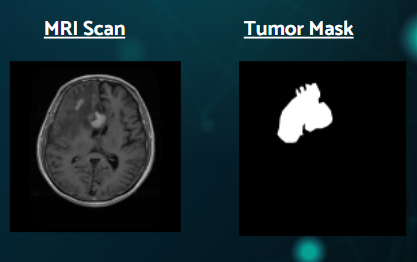


**Problem Statement** \
- Segment the tumor part from the MRI scans of brain.
- Identify the kind of brain tumor from categories : Meningioma, Glioma, Pituitary tumor


Importing the necessary modules

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install tf_keras_vis

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import sys
from glob import glob
from keras.preprocessing import image
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from glob import glob
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE

In [ ]:
from tensorflow.keras import models, Model
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, Dense, InputLayer, BatchNormalization, Input, ReLU, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L1,L2,l1_l2
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.models import save_model, load_model
import pickle
from PIL import Image
import PIL.Image

In [ ]:
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam import Gradcam
from matplotlib import cm
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
seed = 909

# 1. Visualizing the data with tumor mask

In [ ]:
image_datagen = ImageDataGenerator(rescale = 1/255.0, horizontal_flip=True,brightness_range=(0.9,1.1),
                                   zoom_range=[.9,1.1],
                                   fill_mode='nearest')
#mask_datagen = ImageDataGenerator(rescale = 1/255.0, horizontal_flip=True,)
image_datagen_no = ImageDataGenerator(rescale = 1/255.0)
#mask_datagen_no = ImageDataGenerator(rescale = 1/255.0)

train_imagegen = image_datagen.flow_from_directory('/content/drive/MyDrive/Brain_tumor_ai_2_project/AI-2-Project-Brain-Tumor-Segmentation-Dataset/data_new/data/scan/train', target_size=(128, 128), 
                                  color_mode='grayscale', class_mode=None,
                                  batch_size=16, seed=seed, shuffle=False)
train_maskgen = image_datagen.flow_from_directory('/content/drive/MyDrive/Brain_tumor_ai_2_project/AI-2-Project-Brain-Tumor-Segmentation-Dataset/data_new/data/mask/train', target_size=(128, 128), 
                                  color_mode='grayscale', class_mode=None,
                                  batch_size=16, seed=seed, shuffle=False)
val_imagegen = image_datagen_no.flow_from_directory('/content/drive/MyDrive/Brain_tumor_ai_2_project/AI-2-Project-Brain-Tumor-Segmentation-Dataset/data_new/data/scan/validation', target_size=(128, 128), 
                                  color_mode='grayscale', class_mode=None,
                                  batch_size=16, seed=seed, shuffle=False)
val_maskgen = image_datagen_no.flow_from_directory('/content/drive/MyDrive/Brain_tumor_ai_2_project/AI-2-Project-Brain-Tumor-Segmentation-Dataset/data_new/data/mask/validation', target_size=(128, 128), 
                                  color_mode='grayscale', class_mode=None,
                                  batch_size=16, seed=seed, shuffle=False)
test_imagegen = image_datagen_no.flow_from_directory('/content/drive/MyDrive/Brain_tumor_ai_2_project/AI-2-Project-Brain-Tumor-Segmentation-Dataset/data_new/data/scan/test', target_size=(128, 128), 
                                  color_mode='grayscale', class_mode=None,
                                  batch_size=16, seed=seed, shuffle=False)
test_maskgen = image_datagen_no.flow_from_directory('/content/drive/MyDrive/Brain_tumor_ai_2_project/AI-2-Project-Brain-Tumor-Segmentation-Dataset/data_new/data/mask/test', target_size=(128, 128), 
                                  color_mode='grayscale', class_mode=None,
                                  batch_size=16, seed=seed, shuffle=False)



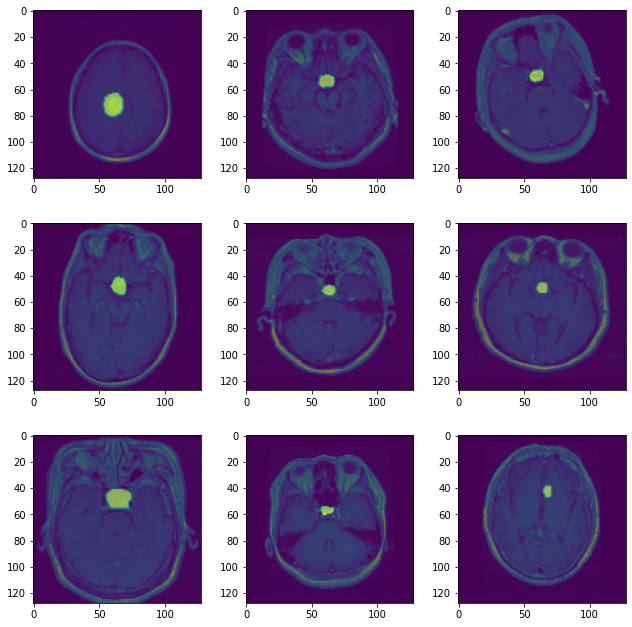

In [ ]:
f,ax = plt.subplots(3,3, figsize=(9,9))
plt.tight_layout()
for i,axs in enumerate(ax.ravel()):
    axs.imshow(train_imagegen[i][1].reshape(128, 128), alpha=1)
    axs.imshow(train_maskgen[i][1].reshape(128, 128), alpha=0.5)

plt.show()

**Observations**
- This figure shows the tumor part in yellow (mask) and the brain MRI scan with data augmentation

# 2. Base Models for Classification




## Base Model 1 : Fully connected neural network
Here, we have intially tried to use the fully connected neural network for classification to see the classification accuracy since it was the neural network we studied first. (We tried it first to see whether its performing good)


We are taking the data from drive

In [ ]:
# rescaling the images to normalize the pixels
datagen = ImageDataGenerator(rescale=1./255,validation_split=0.3)


# to create generators traingen and valgen for training and validating the model
traingen = datagen.flow_from_directory('/content/drive/MyDrive/Univ.ai/AI_2_Project/Scanned_images', 
                                       target_size=(512, 512),
                                       batch_size = 32,
                                       class_mode = 'categorical',
                                       subset = 'training', )

valgen = datagen.flow_from_directory('/content/drive/MyDrive/Univ.ai/AI_2_Project/Scanned_images', 
                                       target_size=(512, 512),
                                       batch_size = 32,
                                       class_mode = 'categorical',
                                       subset = 'validation')

Found 2146 images belonging to 3 classes.
Found 918 images belonging to 3 classes.


- We are defining the basic FFNN model here

In [ ]:
# initializing the Sequential model API for Feed Forward Network
model = Sequential(name='FFNN_model')

# defining L1 regularization with C = 0.1
reg = tf.keras.regularizers.L1(0.1)

# Flattening the input from 3D array to 1D for FFNN model 
model.add(Flatten(input_shape=(512,512,3)))
model.add(Dense(64,activation='relu', kernel_regularizer = reg))
model.add(Dropout(0.3))
model.add(Dense(256,activation='relu', kernel_regularizer = reg))
model.add(Dropout(0.3))
model.add(Dense(256,activation='relu', kernel_regularizer = reg))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))

# Output layer for 3 classes
model.add(Dense(3, activation='softmax'))

# To get summary of the model 
model.summary()

Model: "FFNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 786432)            0         
                                                                 
 dense (Dense)               (None, 64)                50331712  
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 256)               16640     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0

- There is a total of 50,435,203 parameters for this model
- We are going to use early stopping here

In [ ]:
# EarlyStopping with patience = 5
callback = tf.keras.callbacks.EarlyStopping(patience=5)

# compiling the model 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
history = model.fit(traingen, epochs=10, validation_data=valgen,  callbacks=[callback])

Epoch 1/10
68/68 [==============================] - 22s 322ms/step - loss: 559.4828 - accuracy: 0.4655 - val_loss: 550.7508 - val_accuracy: 0.4651
Epoch 2/10
68/68 [==============================] - 21s 309ms/step - loss: 559.5812 - accuracy: 0.4651 - val_loss: 554.1368 - val_accuracy: 0.4651
Epoch 3/10
68/68 [==============================] - 21s 310ms/step - loss: 559.6321 - accuracy: 0.4655 - val_loss: 546.2037 - val_accuracy: 0.4651
Epoch 4/10
68/68 [==============================] - 21s 311ms/step - loss: 559.2198 - accuracy: 0.4655 - val_loss: 550.1909 - val_accuracy: 0.4651
Epoch 5/10
68/68 [==============================] - 21s 309ms/step - loss: 559.2783 - accuracy: 0.4655 - val_loss: 553.5712 - val_accuracy: 0.4651
Epoch 6/10
68/68 [==============================] - 21s 310ms/step - loss: 559.7061 - accuracy: 0.4655 - val_loss: 547.2371 - val_accuracy: 0.4651
Epoch 7/10
68/68 [==============================] - 21s 307ms/step - loss: 559.2169 - accuracy: 0.4655 - val_loss: 549

**Plotting the loss and accuracy**

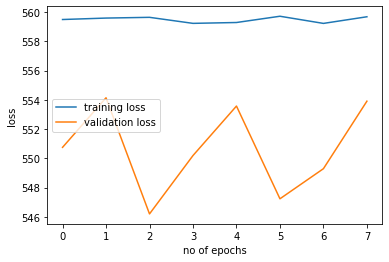

In [ ]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('no of epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

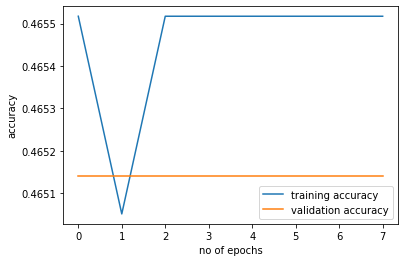

In [ ]:
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('no of epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

**Inference**
- As, you can observe, the loss and accuracy is very bad
- The accuracy is less than 0.5
- We tried changing the things but the accuracy wasn't improving

## Base Model 2 : Convolutional Neural Network

- Next we tried basic CNN as our base model to see the accuracy of the model
- We are defining the model in the cell below

In [ ]:
model = Sequential(name='CNN')

model.add(Input(shape=(512,512,3)))
model.add(Conv2D(128, (3,3), activation='relu', strides=2, padding = 'same'))
model.add(Conv2D(256, (3,3), activation='relu', strides=2, padding = 'same'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(256, (7,7), activation='relu', strides=2, padding = 'same'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(512, (5,5), activation='relu', strides=2, padding = 'same'))
model.add(Conv2D(256, (3,3), activation='relu', strides=2, padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 256, 256, 128)     46592     
                                                                 
 conv2d_25 (Conv2D)          (None, 128, 128, 256)     2654464   
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 42, 42, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 21, 21, 256)       3211520   
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 7, 7, 256)        0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 4, 4, 512)         3277312 

- There is a total of 10,452,227 parameters in this model
- We are compiling the model here

In [ ]:
model.compile(metrics=['accuracy'], loss='categorical_crossentropy', optimizer='adam')

history2 = model.fit(traingen, validation_data=valgen, epochs=10)

Epoch 1/10
68/68 [==============================] - 137s 1s/step - loss: 0.9332 - accuracy: 0.5391 - val_loss: 0.5733 - val_accuracy: 0.7549
Epoch 2/10
68/68 [==============================] - 91s 1s/step - loss: 0.5059 - accuracy: 0.7684 - val_loss: 0.4358 - val_accuracy: 0.8715
Epoch 3/10
68/68 [==============================] - 91s 1s/step - loss: 0.4121 - accuracy: 0.8145 - val_loss: 0.4285 - val_accuracy: 0.8486
Epoch 4/10
68/68 [==============================] - 91s 1s/step - loss: 0.3222 - accuracy: 0.8523 - val_loss: 0.3147 - val_accuracy: 0.8976
Epoch 5/10
68/68 [==============================] - 91s 1s/step - loss: 0.2918 - accuracy: 0.8733 - val_loss: 0.4415 - val_accuracy: 0.8878
Epoch 6/10
68/68 [==============================] - 91s 1s/step - loss: 0.2356 - accuracy: 0.8928 - val_loss: 0.3065 - val_accuracy: 0.9107
Epoch 7/10
68/68 [==============================] - 91s 1s/step - loss: 0.1969 - accuracy: 0.9175 - val_loss: 0.3237 - val_accuracy: 0.9118
Epoch 8/10
68/68 [=

**Plotting loss and accuracy**

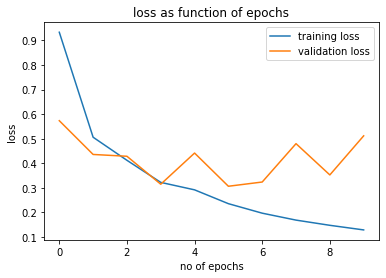

In [ ]:
plt.plot(history2.history['loss'], label='training loss')
plt.plot(history2.history['val_loss'], label='validation loss')
plt.xlabel('no of epochs')
plt.ylabel('loss')
plt.title('loss as function of epochs')
plt.legend()
plt.show()

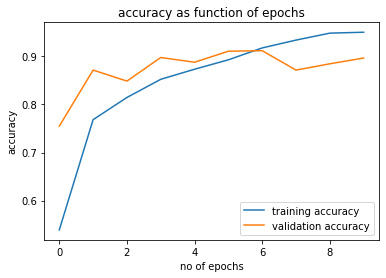

In [ ]:
plt.plot(history2.history['accuracy'], label='training accuracy')
plt.plot(history2.history['val_accuracy'], label='validation accuracy')
plt.xlabel('no of epochs')
plt.ylabel('accuracy')
plt.title('accuracy as function of epochs')
plt.legend()
plt.show()

**Inference**
- As you can observe it is giving good accuracy 
- But we don't know whether it's because of the tumor or the whole brain data itself
- Since, the aim is to predict the tumor based on the tumor data we need to check from what it is predicting from 
- So we are doing some saliency maps to see how our model is predicting the results


**Saliency maps**
- We are checking the smoothgrad and gradcam of this model to see from what part of the pixels the model is classifying the data

In [ ]:
replace2linear = ReplaceToLinear()
score = CategoricalScore([1])
img = valgen[2][0][6]

In [ ]:
# Saliency map
saliency = Saliency(model,
                    model_modifier=replace2linear,
                    )

saliency_map = saliency(score,img,smooth_samples=2, smooth_noise=0.05)

# GradCAM
gradcam = Gradcam(model,
                  model_modifier=replace2linear,
                  clone=True)

cam = gradcam(score,
              img, penultimate_layer=-1)


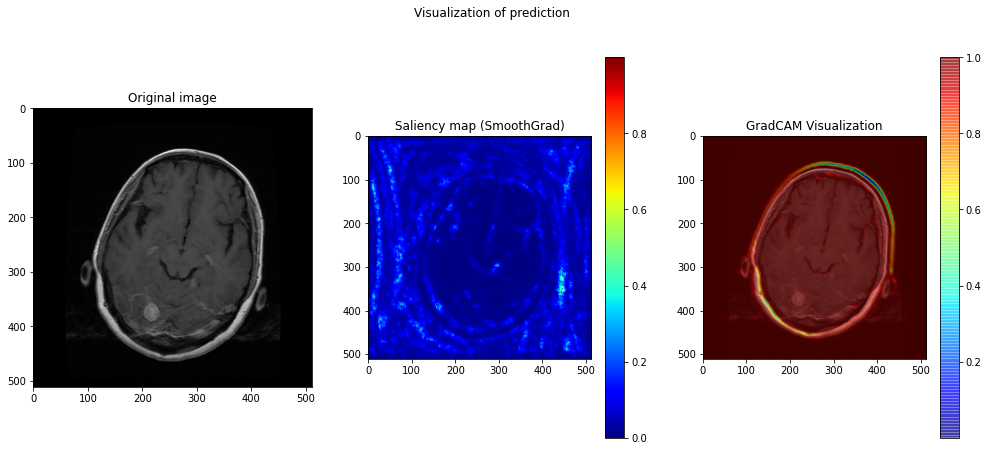

In [ ]:
plt.figure(figsize=(17,7))

plt.subplot(1,3,1)
plt.imshow(img)
plt.title('Original image')

plt.subplot(1,3,2)
plt.imshow(saliency_map[0], cmap='jet')
plt.title('Saliency map (SmoothGrad)')
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(img)
plt.imshow(1-cam.squeeze(), cmap='jet', alpha=0.5)
plt.title('GradCAM Visualization')
plt.colorbar()

plt.suptitle("Visualization of prediction")
plt.show()

**Inference**
- From the above figures we can observe that it takes the whole image of brain to predict the tumor (we observed the same with other images too)
- But what we want is the to find the tumor area and use it for prediction
- So,  we will be doing the segmentation of the tumor from the brain mri using the tumor mask to get the information of the tumor rather than of the whole image 

# Losses Used


We are defining the losses we used for this problem of segmentation is given below. 

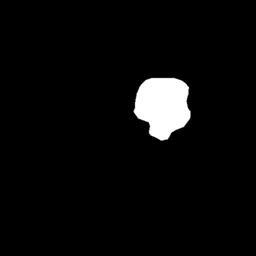  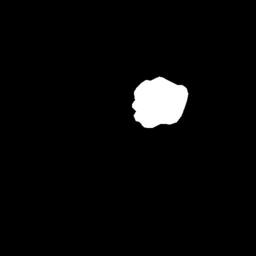  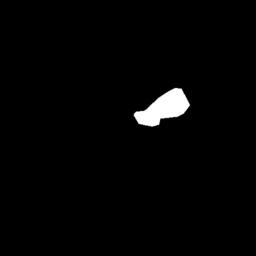



---
**Why we need a different loss??** \
*As per above tumor mask, we can see that about 80% of the image is background or not a tumor part. Therefor using binary crossentropy did not seem to be optimal. Therefore we have used multiple loss with combining them to increase the effects of each of them.*


#### Dice Loss

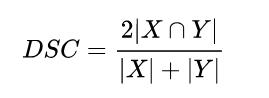

The idea behind the dice loss is that we calculate the intersection between actual and predicted segment of tumor. DCE is the dice co-efficient which is the intersection divided by sum of actual and predicted mask. when predicted and actual mask is equal then DCE becomes 1. So we calculate the loss by 1 - DCE.

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

#### Focal Loss

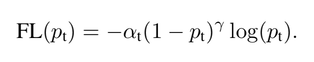

The focal loss as name suggests used for focusing on incorrect prediction. If a datapoint is far away from its prediction then (1 - P(t)) is powered by a parameter gamma gi

In [ ]:
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1+K.epsilon())) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
    return focal_loss_fixed

## IOU metric
(This is the metric we used to find the efficiency of the segmentation i.e., maximum IOU metrics implies good segmentation. )

For implementation of Mean IoU, We averaged over the percentage of correctly classfied pixels in the image. It provides better clues about what is going on inside the model compare to accuracy as we have class imabalance.

In [ ]:
def mean_iou(y_true, y_pred):
    y_pred = K.cast(K.greater(y_pred, .5), dtype='float32') # .5 is the threshold
    ones = K.sum(K.flatten(y_pred * y_true)) / K.sum(K.flatten(y_true))
    y_pred = K.cast(K.equal(y_pred, 0), dtype='float32')
    y_true = K.cast(K.equal(y_true, 0), dtype='float32')
    zeros = K.sum(K.flatten(y_pred * y_true)) / K.sum(K.flatten(y_true))
    return (ones + zeros)/2.0

## Combining losses

**Why did we use the combined losses?** \
*After few interations, we noticed that no losses used individually gives good performance. Only binary crossentropy gives somewhat good results. Therefore we chose to combine 3 loss functions : Binary Crossentropy, Dice loss, Focal loss.*

*As all three loss provides different affects, combining them should give better results and it did as compared to all individual loss.*

In [ ]:
def focal_dice_crosse(y_true, y_pred):
    bce = BinaryCrossentropy()
    return bce(y_true, y_pred) + dice_coef_loss(y_true, y_pred) + focal_loss()(y_true, y_pred)

# 3. Segmentation Models and Classification

## 1. Segmentation : Base Autoencoder
Here, we are using the basic autoencoder architecture we studied in the course to segment the tumor region. 

Data Imports

In [ ]:
image_datagen = ImageDataGenerator(rescale = 1/255)
mask_datagen = ImageDataGenerator(rescale = 1/255)

train_imagegen = image_datagen.flow_from_directory('scan+mask/train/scan', target_size=(512, 512), 
                                  color_mode='grayscale', class_mode=None,
                                  batch_size=16, seed=seed, shuffle=False)
train_maskgen = mask_datagen.flow_from_directory('scan+mask/train/mask', target_size=(512, 512), 
                                  color_mode='grayscale', class_mode=None,
                                  batch_size=16, seed=seed, shuffle=False)
val_imagegen = image_datagen.flow_from_directory('scan+mask/val/scan', target_size=(512, 512), 
                                  color_mode='grayscale', class_mode=None,
                                  batch_size=16, seed=seed, shuffle=False)
val_maskgen = mask_datagen.flow_from_directory('scan+mask/val/mask', target_size=(512, 512), 
                                  color_mode='grayscale', class_mode=None,
                                  batch_size=16, seed=seed, shuffle=False)
test_imagegen = image_datagen.flow_from_directory('scan+mask/test/scan', target_size=(512, 512), 
                                  color_mode='grayscale', class_mode=None,
                                  batch_size=16, seed=seed, shuffle=False)
test_maskgen = mask_datagen.flow_from_directory('scan+mask/test/mask', target_size=(512, 512), 
                                  color_mode='grayscale', class_mode=None,
                                  batch_size=16, seed=seed, shuffle=False)

Found 1838 images belonging to 1 classes.
Found 1838 images belonging to 1 classes.
Found 613 images belonging to 1 classes.
Found 613 images belonging to 1 classes.
Found 613 images belonging to 1 classes.
Found 613 images belonging to 1 classes.


Basic Autoencoder model implementation

In [ ]:
#model1
filters = [32,32,64,64,128,128]
k_size = [5,5,4,3,3,2]

filters_t = [128,64,32,32,16,1]
k_size_t = [2,3,3,4,5,5]
activation = ['relu','relu','relu','relu','relu','sigmoid']

model1 = models.Sequential()

#encoder
model1.add(InputLayer(input_shape = (512,512,1)))

for f,k in zip(filters,k_size): 
    model1.add(Conv2D(f, kernel_size = k, strides=(1,1), padding="same", activation='relu'))
    #autoenc.add(BatchNormalization())
    model1.add(MaxPooling2D(pool_size=(2,2)))

#decoder
for f,k,a in zip(filters_t,k_size_t,activation): 
    model1.add(Conv2DTranspose(f, kernel_size=k, strides=(2,2), padding="same", activation=a))
    #autoenc.add(BatchNormalization())

model1.compile(optimizer = Adam(learning_rate=1e-3), loss=focal_dice_crosse, metrics = [mean_iou, 'accuracy'], run_eagerly=True)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 512, 512, 32)      832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      32832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        3

- This contains a total of 423,297 parameters
- Early stopping is used so that the model won't overfit the results

In [ ]:
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    mode="auto",
    restore_best_weights=True,
)

In [ ]:
history = model.fit(zip(train_imagegen,train_maskgen), epochs=60, steps_per_epoch = 114, 
            validation_data= zip(val_imagegen, val_maskgen), validation_steps=38,validation_batch_size=16, workers=-1,
            use_multiprocessing=True, callbacks= [es_callback], )

Epoch 1/60
114/114 [==============================] - 65s 490ms/step - loss: 1.2226 - mean_iou: 0.5000 - accuracy: 0.9756 - val_loss: 1.0249 - val_mean_iou: 0.5000 - val_accuracy: 0.9808
Epoch 2/60
114/114 [==============================] - 51s 450ms/step - loss: 1.0086 - mean_iou: 0.5000 - accuracy: 0.9811 - val_loss: 1.0180 - val_mean_iou: 0.5000 - val_accuracy: 0.9807
Epoch 3/60
114/114 [==============================] - 51s 447ms/step - loss: 1.0049 - mean_iou: 0.5000 - accuracy: 0.9811 - val_loss: 1.0119 - val_mean_iou: 0.5000 - val_accuracy: 0.9811
Epoch 4/60
114/114 [==============================] - 52s 456ms/step - loss: 1.0021 - mean_iou: 0.5000 - accuracy: 0.9811 - val_loss: 0.9972 - val_mean_iou: 0.5000 - val_accuracy: 0.9809
Epoch 5/60
114/114 [==============================] - 53s 462ms/step - loss: 0.9999 - mean_iou: 0.5000 - accuracy: 0.9812 - val_loss: 1.0001 - val_mean_iou: 0.5000 - val_accuracy: 0.9812
Epoch 6/60
114/114 [==============================] - 53s 461ms/s

Epoch 45/60
114/114 [==============================] - 77s 652ms/step - loss: 0.2770 - mean_iou: 0.8697 - accuracy: 0.9904 - val_loss: 0.6279 - val_mean_iou: 0.7031 - val_accuracy: 0.9836
Epoch 46/60
114/114 [==============================] - 54s 477ms/step - loss: 0.2763 - mean_iou: 0.8695 - accuracy: 0.9904 - val_loss: 0.6052 - val_mean_iou: 0.7458 - val_accuracy: 0.9824
Epoch 47/60
114/114 [==============================] - 55s 483ms/step - loss: 0.2888 - mean_iou: 0.8662 - accuracy: 0.9900 - val_loss: 0.6692 - val_mean_iou: 0.6759 - val_accuracy: 0.9836
Epoch 48/60
114/114 [==============================] - 55s 479ms/step - loss: 0.2613 - mean_iou: 0.8774 - accuracy: 0.9906 - val_loss: 0.5445 - val_mean_iou: 0.7603 - val_accuracy: 0.9843
Epoch 49/60
114/114 [==============================] - 56s 489ms/step - loss: 0.2505 - mean_iou: 0.8817 - accuracy: 0.9909 - val_loss: 0.5458 - val_mean_iou: 0.8063 - val_accuracy: 0.9825
Epoch 50/60
114/114 [==============================] - 85s 7

**Plots for the loss and Mean IoU**
- We use the mean IoU metric here instead of accuracy since the tumor region is unbalanced compared to the non-tumor region and accuracy won't make sense. 
- And the loss we used here is the combination of adding binary crossentropy, focal loss and dice loss 

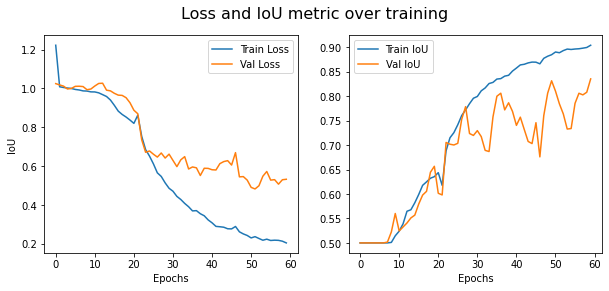

In [ ]:
f,ax = plt.subplots(1,2, figsize=(10, 4))
f.suptitle('Loss and IoU metric over training', fontsize=16)

ax[0].plot(hist['loss'], label="Train Loss")
ax[0].plot(hist['val_loss'], label="Val Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")


ax[1].plot(hist['mean_iou'], label="Train IoU")
ax[1].plot(hist['val_mean_iou'], label="Val IoU")
ax[1].set_xlabel("Epochs")
ax[0].set_ylabel("IoU")

ax[0].legend()
ax[1].legend()
plt.show()

**Inference**
- We can observe that the loss is decreasing and the mean IoU metric is improving
- But we need to be sure whether it is segmenting based on the tumor information or not

Visualizing Predictions From Validation Data

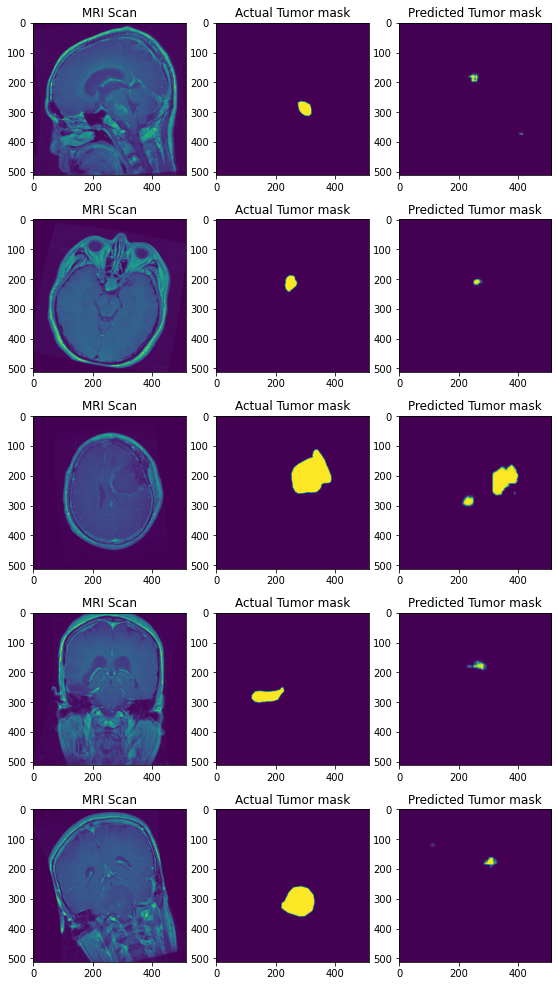

In [ ]:
f,ax = plt.subplots(5,3, figsize=(12,12))


for i in range(5):
    batch = random.randint(0,38)
    img = random.randint(0,15)
    
    ax[i][0].imshow(val_imagegen[batch][img])
    ax[i][0].set_title("MRI Scan")
    
    ax[i][1].imshow(val_maskgen[batch][img])
    ax[i][1].set_title("Actual Tumor mask")
    
    ax[i][2].imshow(model.predict(val_imagegen[batch][img].reshape(1,512,512,1)).reshape(512,512))
    ax[i][2].set_title("Predicted Tumor mask")
    
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.7, 
                    top=1.2)

plt.show()

Visualizing Prediction from test data

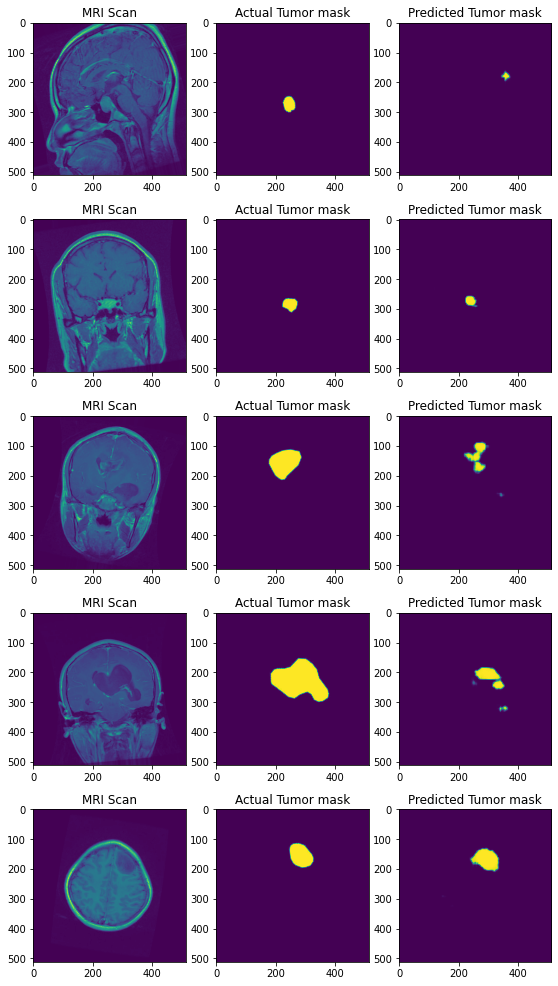

In [ ]:
f,ax = plt.subplots(5,3, figsize=(12,12))


for i in range(5):
    batch = random.randint(0,37)
    img = random.randint(0,15)
    
    ax[i][0].imshow(test_imagegen[batch][img])
    ax[i][0].set_title("MRI Scan")
    
    ax[i][1].imshow(test_maskgen[batch][img])
    ax[i][1].set_title("Actual Tumor mask")
    
    ax[i][2].imshow(model.predict(test_imagegen[batch][img].reshape(1,512,512,1)).reshape(512,512))
    ax[i][2].set_title("Predicted Tumor mask")
    
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.7, 
                    top=1.2)

plt.show()

**Inference**
- We can observe that the model is segmenting the image 

**TSNE**
- We do TSNE to see how well the model has encoded the data, for that we define the model for the encoder part

In [ ]:
class_imagegen = image_datagen.flow_from_directory('for-tsne/', target_size=(512, 512), 
                                  color_mode='grayscale', class_mode='categorical',
                                  batch_size=1500, seed=seed, shuffle=True)

Found 3064 images belonging to 3 classes.


In [ ]:
encoder_input = Input(shape=model.layers[0].input_shape[1:])
encoder_model = encoder_input
for layer in model.layers[0:12]:
    encoder_model = layer(encoder_model)

encoder_model = Model(inputs = encoder_input, outputs = encoder_model)

In [ ]:
tsne_out = TSNE(n_components=2, learning_rate='auto', init='pca').fit_transform(K.batch_flatten(encoder_model.predict(class_imagegen[0][0])))

D:\Programs\Anaconda\envs\tf2.8\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


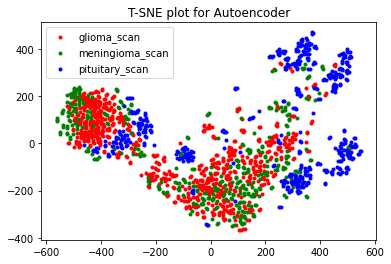

In [ ]:
idx = (class_imagegen[0][1] == 1)
sc0 = plt.scatter(tsne_out[idx[:,0],0], tsne_out[idx[:,0],1],  marker='.', color='red')
sc1 = plt.scatter(tsne_out[idx[:,1],0], tsne_out[idx[:,1],1],  marker='.', color='green')
sc2 = plt.scatter(tsne_out[idx[:,2],0], tsne_out[idx[:,2],1],  marker='.', color='blue')

plt.title("T-SNE plot for Autoencoder")
plt.legend((sc0,sc1,sc2),(class_imagegen.class_indices))
plt.show()

**Inference**
- From the plot above we can observe that the encoded layers doesn't separate the tumors clearly
- It might be because we are were using it for segmentation not for classification feature extraction

**Saliency Maps**
- We are doing saliency maps to see whether the autoencoder is extracting data from the tumor region or not

In [ ]:
def score_function_grad(output):
    return mean_iou(output, y)

def score_function(output):
    return output

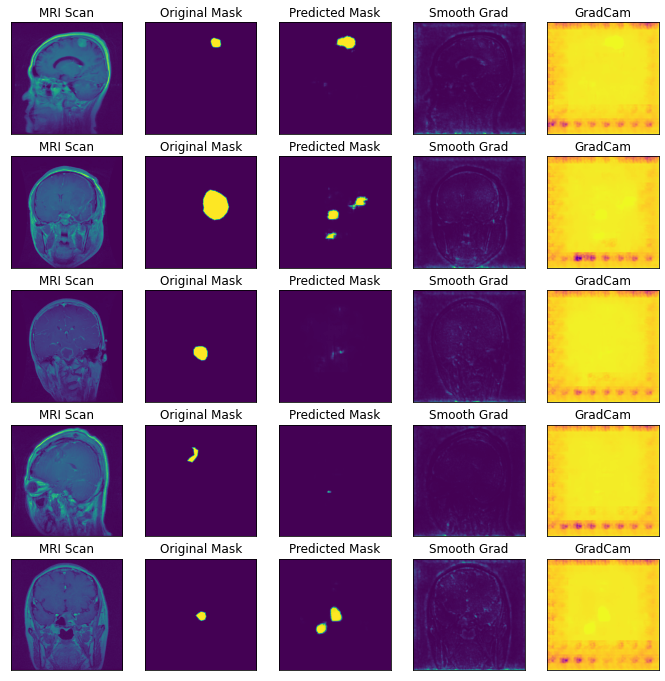

In [ ]:
f,ax = plt.subplots(5,5, figsize=(15,15))

for a in ax.ravel():
    a.set_xticks([])
    a.set_yticks([])

for i in range(5):
    
    batch = random.randint(0,37)
    img = random.randint(0,15)
    
    X = np.expand_dims(test_imagegen[batch][img], axis=0)
    y = np.expand_dims(test_maskgen[batch][img], axis=0)

    saliency = Saliency(model, 
                        model_modifier=ReplaceToLinear(),
                        clone=True)
    saliency_map = saliency(score_function, X,
                            smooth_samples =20,
                            smooth_noise= 0.20)
    cm = normalize(saliency_map)

    gradcam = Gradcam(model,
                      model_modifier=ReplaceToLinear(),
                      clone=True)

    cam = gradcam(score_function_grad,
                  X,
                  penultimate_layer=-1)
        
    
    ax[i][0].imshow(X.squeeze())
    ax[i][0].set_title("MRI Scan")
    
    ax[i][1].imshow(y.squeeze())
    ax[i][1].set_title("Original Mask")

    ax[i][2].imshow(model.predict(X).squeeze())
    ax[i][2].set_title("Predicted Mask")    

    ax[i][3].imshow(cm.squeeze(),cmap='viridis')
    ax[i][3].set_title("Smooth Grad")
    
    # Here, 1-cam is used cause the score function is mean_iou which is like accuracy not loss
    ax[i][4].imshow(1-cam.squeeze(),cmap='plasma')
    ax[i][4].set_title("GradCam")
    
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.7, 
                    top=0.7)


plt.show()

**Inference**
- Even though, the we got good mean IOU metric the saliency maps shows that the model is taking the information from the whole brain 
- So, it might be segmenting based on the shape of the brain or something like that
- We need a better way to segment based on the region of interest

## 2. Segmentation: Simple Version of UNET

- After some research we found UNET architecture is used for the bio-medical image segmentation

**What is UNET?**
- It is basically a autoencoder in which in the encoder part we will reduce the size of the image but increase the depth to know "WHAT" is in the image
- In the decoder we will decrease the depth and increase the size of the image
- But the difference is that it will find the "WHERE" or precise location of the region of interest using the skip connections in the decoder layer i.e., concatenating output of transpose convolution with feature maps from the encoder of same 
- This skip connections preserve the "WHERE" information which helps in selecting the tumor region as out region of interest 

**This link helped for simple u-net:** https://blog.paperspace.com/unet-architecture-image-segmentation/


Data import

In [ ]:
image_datagen = ImageDataGenerator(rescale = 1/255)
mask_datagen = ImageDataGenerator(rescale = 1/255)

train_imagegen = image_datagen.flow_from_directory('scan+mask/train/scan', target_size=(512, 512), 
                                  color_mode='grayscale', class_mode=None,
                                  batch_size=16, seed=seed, shuffle=False)
train_maskgen = mask_datagen.flow_from_directory('scan+mask/train/mask', target_size=(512, 512), 
                                  color_mode='grayscale', class_mode=None,
                                  batch_size=16, seed=seed, shuffle=False)
val_imagegen = image_datagen.flow_from_directory('scan+mask/val/scan', target_size=(512, 512), 
                                  color_mode='grayscale', class_mode=None,
                                  batch_size=16, seed=seed, shuffle=False)
val_maskgen = mask_datagen.flow_from_directory('scan+mask/val/mask', target_size=(512, 512), 
                                  color_mode='grayscale', class_mode=None,
                                  batch_size=16, seed=seed, shuffle=False)
test_imagegen = image_datagen.flow_from_directory('scan+mask/test/scan', target_size=(512, 512), 
                                  color_mode='grayscale', class_mode=None,
                                  batch_size=16, seed=seed, shuffle=False)
test_maskgen = mask_datagen.flow_from_directory('scan+mask/test/mask', target_size=(512, 512), 
                                  color_mode='grayscale', class_mode=None,
                                  batch_size=16, seed=seed, shuffle=False)

Found 1838 images belonging to 1 classes.
Found 1838 images belonging to 1 classes.
Found 613 images belonging to 1 classes.
Found 613 images belonging to 1 classes.
Found 613 images belonging to 1 classes.
Found 613 images belonging to 1 classes.


In [ ]:
# model-2 inspired by u-net

def convolution(inputs, filters = 32):
    conv1 = Conv2D(filters, kernel_size=(3,3), padding="same", strides=(1,1))(inputs)
    #batch_norm1 = BatchNormalization()(conv1)
    relu1 = ReLU()(conv1)
    
    conv2 = Conv2D(filters, kernel_size=(3,3), padding="same", strides=(1,1))(relu1)
    #batch_norm2 = BatchNormalization()(conv2)
    relu2 = ReLU()(conv2)
    
    return relu2
    
def encoder(inputs, filters = 32):
    cv = convolution(inputs, filters)
    maxpool = MaxPooling2D(pool_size=(4,4))(cv)
    return (cv,maxpool)

def decoder(inputs, skips , filters = 32):
    cv1 = Conv2DTranspose(filters, kernel_size=(3,3), padding="same", strides=(4,4))(inputs)
    concate = Concatenate()([cv1, skips])
    cv2 = convolution(concate, filters)
    return cv2

def U_Net(image_size):
    input1 = Input(image_size)
    
    # Construct the encoder blocks
    skip1, encoder_1 = encoder(input1, 16)
    skip2, encoder_2 = encoder(encoder_1, 16*2)
    skip3, encoder_3 = encoder(encoder_2, 16*4)
    skip4, encoder_4 = encoder(encoder_3, 16*8)
    
    # Preparing the next block
    conv_block = convolution(encoder_4, 16*16)
    
    # Construct the decoder blocks
    decoder_1 = decoder(conv_block, skip4, 16*8)
    decoder_2 = decoder(decoder_1, skip3, 16*4)
    decoder_3 = decoder(decoder_2, skip2, 16*2)
    decoder_4 = decoder(decoder_3, skip1, 16)
    
    out = Conv2D(1, 1, padding="same", activation="sigmoid")(decoder_4)

    model = Model(input1, out)
    return model

model = U_Net((512,512,1))
model.compile(optimizer = Adam(learning_rate=1e-3), loss=focal_dice_crosse, metrics = [mean_iou, 'accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 512, 512, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 2320        re_lu[0][0]                      
______________________________________________________________________________________________

- This is a simple UNET with less number of parameters i.e., 2,158,417

**Plots for mean IoU metrics and Loss**
- As mentioned before the mean IoU is used because of the imbalance in pixel level of the data (i.e., tumor region and non-tumor region)

In [ ]:
history = model.fit(zip(train_imagegen,train_maskgen), epochs=100, steps_per_epoch = 114, 
            validation_data= zip(val_imagegen, val_maskgen), validation_steps=38,validation_batch_size=16, workers=-1,
            use_multiprocessing=True)
hist = history.history

Epoch 1/100
114/114 [==============================] - 85s 673ms/step - loss: 1.0647 - mean_iou: 0.5000 - accuracy: 0.9811 - val_loss: 0.9740 - val_mean_iou: 0.5000 - val_accuracy: 0.9808
Epoch 2/100
114/114 [==============================] - 85s 707ms/step - loss: 0.9838 - mean_iou: 0.5263 - accuracy: 0.9751 - val_loss: 0.9550 - val_mean_iou: 0.5519 - val_accuracy: 0.9720
Epoch 3/100
114/114 [==============================] - 82s 718ms/step - loss: 0.9687 - mean_iou: 0.5404 - accuracy: 0.9766 - val_loss: 0.9350 - val_mean_iou: 0.5690 - val_accuracy: 0.9803
Epoch 4/100
114/114 [==============================] - 82s 722ms/step - loss: 0.9221 - mean_iou: 0.6063 - accuracy: 0.9748 - val_loss: 0.8946 - val_mean_iou: 0.6566 - val_accuracy: 0.9752
Epoch 5/100
114/114 [==============================] - 83s 726ms/step - loss: 0.8700 - mean_iou: 0.6442 - accuracy: 0.9767 - val_loss: 0.8579 - val_mean_iou: 0.6166 - val_accuracy: 0.9802
Epoch 6/100
114/114 [==============================] - 83s 7

114/114 [==============================] - 83s 726ms/step - loss: 0.1451 - mean_iou: 0.9339 - accuracy: 0.9932 - val_loss: 0.3790 - val_mean_iou: 0.8333 - val_accuracy: 0.9877
Epoch 88/100
114/114 [==============================] - 83s 726ms/step - loss: 0.1482 - mean_iou: 0.9349 - accuracy: 0.9931 - val_loss: 0.3852 - val_mean_iou: 0.8207 - val_accuracy: 0.9878
Epoch 89/100
114/114 [==============================] - 84s 737ms/step - loss: 0.1446 - mean_iou: 0.9348 - accuracy: 0.9932 - val_loss: 0.4005 - val_mean_iou: 0.8104 - val_accuracy: 0.9877
Epoch 90/100
114/114 [==============================] - 84s 738ms/step - loss: 0.1427 - mean_iou: 0.9363 - accuracy: 0.9932 - val_loss: 0.3545 - val_mean_iou: 0.8397 - val_accuracy: 0.9883
Epoch 91/100
114/114 [==============================] - 84s 736ms/step - loss: 0.1339 - mean_iou: 0.9394 - accuracy: 0.9935 - val_loss: 0.4051 - val_mean_iou: 0.8208 - val_accuracy: 0.9871
Epoch 92/100
114/114 [==============================] - 83s 730ms/st

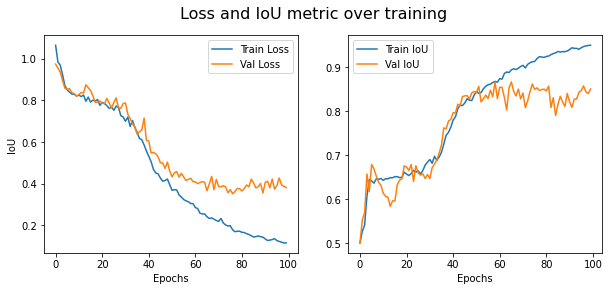

In [ ]:
f,ax = plt.subplots(1,2, figsize=(10, 4))
f.suptitle('Loss and IoU metric over training', fontsize=16)

ax[0].plot(hist['loss'], label="Train Loss")
ax[0].plot(hist['val_loss'], label="Val Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")


ax[1].plot(hist['mean_iou'], label="Train IoU")
ax[1].plot(hist['val_mean_iou'], label="Val IoU")
ax[1].set_xlabel("Epochs")
ax[0].set_ylabel("IoU")

ax[0].legend()
ax[1].legend()
plt.show()

**Inference**
- We can observe that the loss is decreasing and mean IoU is increasing which means our model is segmenting properly

Visualizing prediction on Validation data

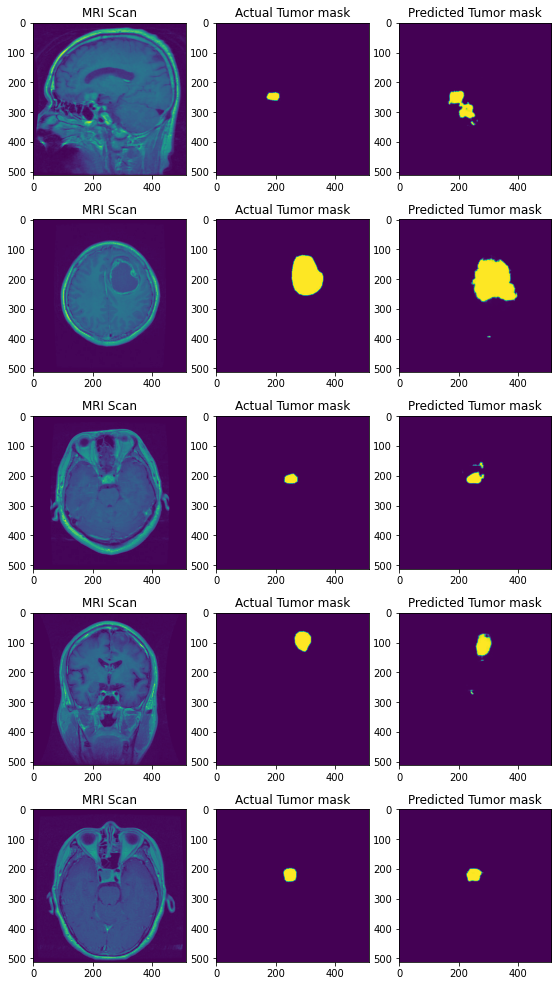

In [ ]:
f,ax = plt.subplots(5,3, figsize=(12,12))


for i in range(5):
    batch = random.randint(0,38)
    img = random.randint(0,15)
    
    ax[i][0].imshow(val_imagegen[batch][img])
    ax[i][0].set_title("MRI Scan")
    
    ax[i][1].imshow(val_maskgen[batch][img])
    ax[i][1].set_title("Actual Tumor mask")
    
    ax[i][2].imshow(model.predict(val_imagegen[batch][img].reshape(1,512,512,1)).reshape(512,512))
    ax[i][2].set_title("Predicted Tumor mask")
    
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.7, 
                    top=1.2)

plt.show()

Visualizing prediction on test data

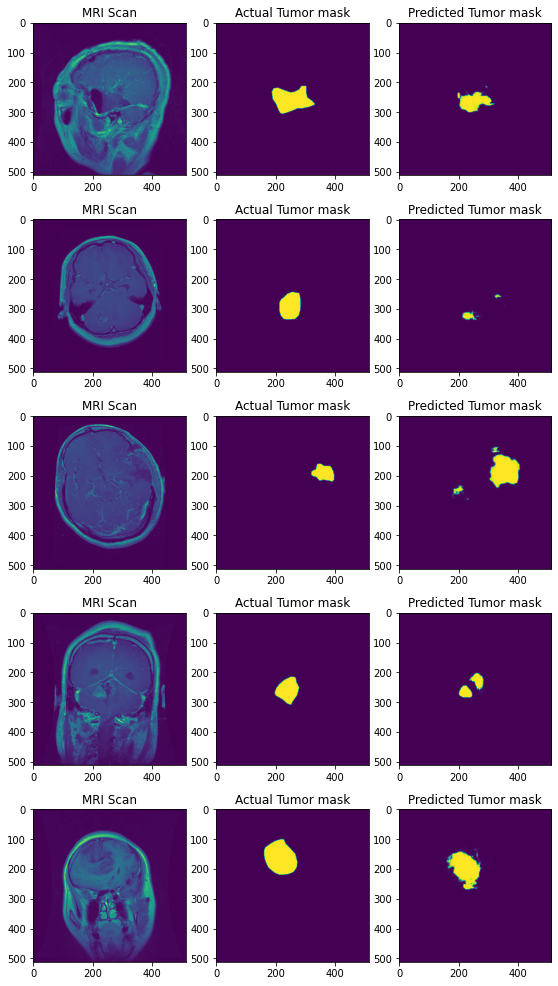

In [ ]:
f,ax = plt.subplots(5,3, figsize=(12,12))


for i in range(5):
    batch = random.randint(0,37)
    img = random.randint(0,15)
    
    ax[i][0].imshow(test_imagegen[batch][img])
    ax[i][0].set_title("MRI Scan")
    
    ax[i][1].imshow(test_maskgen[batch][img])
    ax[i][1].set_title("Actual Tumor mask")
    
    ax[i][2].imshow(model.predict(test_imagegen[batch][img].reshape(1,512,512,1)).reshape(512,512))
    ax[i][2].set_title("Predicted Tumor mask")
    
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.7, 
                    top=1.2)

plt.show()

- We can observe how the model segments the image from the plots above comparing it with the mask provided in the dataset

**TSNE**
- We do TSNE to see how well the model has encoded the data, for that we define the model for the encoder part

In [ ]:
class_imagegen = image_datagen.flow_from_directory('for-tsne/', target_size=(512, 512), 
                                  color_mode='grayscale', class_mode='categorical',
                                  batch_size=1500, seed=seed, shuffle=True)

Found 3064 images belonging to 3 classes.


In [ ]:
encoder_input = Input(shape=model.layers[0].input_shape[0][1:])
encoder_model = encoder_input
for layer in model.layers[1:25]:
    encoder_model = layer(encoder_model)

encoder_model = Model(inputs = encoder_input, outputs = encoder_model)

In [ ]:
tsne_out = TSNE(n_components=2, learning_rate='auto', init='pca').fit_transform(K.batch_flatten(encoder_model.predict(class_imagegen[0][0])))

D:\Programs\Anaconda\envs\tf2.8\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


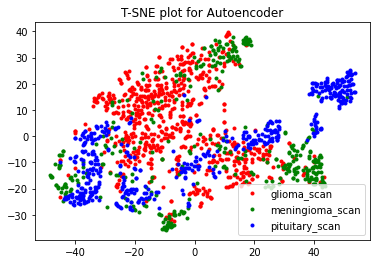

In [ ]:
idx = (class_imagegen[0][1] == 1)
sc0 = plt.scatter(tsne_out[idx[:,0],0], tsne_out[idx[:,0],1],  marker='.', color='red')
sc1 = plt.scatter(tsne_out[idx[:,1],0], tsne_out[idx[:,1],1],  marker='.', color='green')
sc2 = plt.scatter(tsne_out[idx[:,2],0], tsne_out[idx[:,2],1],  marker='.', color='blue')

plt.title("T-SNE plot for Autoencoder")
plt.legend((sc0,sc1,sc2),(class_imagegen.class_indices))
plt.show()

**Inference**
- From the plot above we can observe that the encoded layers doesn't separate the tumors clearly
- It might be because we are were using it for segmentation not for classification feature extraction

**Saliency Maps**
- We are doing the saliency maps to see whether the model is looking at the tumor region or not for the segmentation

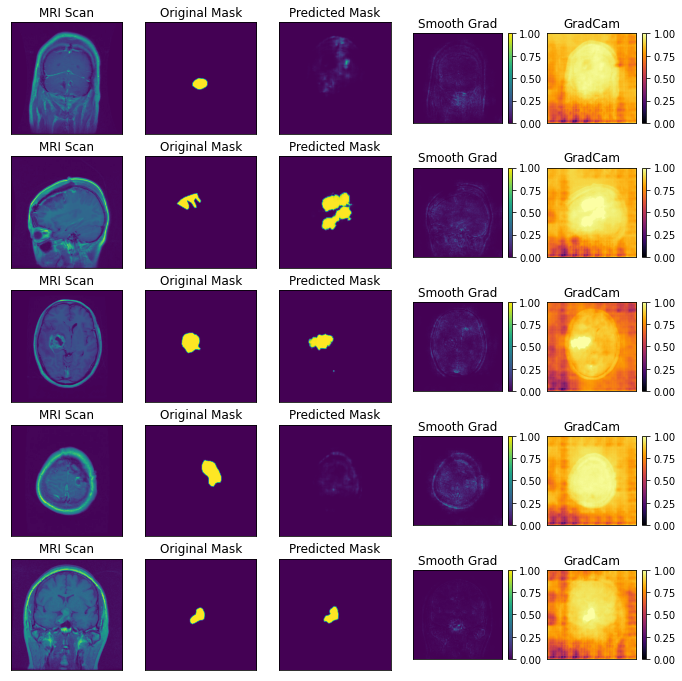

In [ ]:
def score_function_grad(output):
    return mean_iou(output, y)

def score_function(output):
    return output
f,ax = plt.subplots(5,5, figsize=(15,15))

for a in ax.ravel():
    a.set_xticks([])
    a.set_yticks([])

for i in range(5):
    
    batch = random.randint(0,37)
    img = random.randint(0,15)
    
    X = np.expand_dims(test_imagegen[batch][img], axis=0)
    y = np.expand_dims(test_maskgen[batch][img], axis=0)

    saliency = Saliency(model, 
                        model_modifier=ReplaceToLinear(),
                        clone=True)
    saliency_map = saliency(score_function, X,
                            smooth_samples =20,
                            smooth_noise= 0.20)
    cm = normalize(saliency_map)

    gradcam = Gradcam(model,
                      model_modifier=ReplaceToLinear(),
                      clone=True)

    cam = gradcam(score_function_grad,
                  X,
                  penultimate_layer=-1)
        
    
    ax[i][0].imshow(X.squeeze())
    ax[i][0].set_title("MRI Scan")
    
    ax[i][1].imshow(y.squeeze())
    ax[i][1].set_title("Original Mask")

    ax[i][2].imshow(model.predict(X).squeeze())
    ax[i][2].set_title("Predicted Mask")    

    ax[i][3].imshow(cm.squeeze(),cmap='viridis')
    ax[i][3].set_title("Smooth Grad")
    f.colorbar(mappable = matplotlib.cm.ScalarMappable(norm=None, cmap='viridis'), ax=ax[i][3], shrink=0.8)
    
    ax[i][4].imshow(1 - cam.squeeze(),cmap='inferno')
    ax[i][4].set_title("GradCam")
    f.colorbar(mappable = matplotlib.cm.ScalarMappable(norm=None, cmap='inferno'), ax=ax[i][4], shrink=0.8)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.7, 
                    top=0.7)


plt.show()

**Inference**
- From the plots above for gradcam we can see that the model is looking at the tumor region for the segmentation 
- So we move forward with classification

**Classification based on latent layer**
**Classification** 
- Since, we want to do the classification based on the tumor information we are trying to do the classification using the encoder layers of the UNET till the latent space and build the classification model after that. 

**Hypothesis**
- Since, we are segmenting the image to the same space i.e., (512, 512) to (512, 512) we assume that the information about location of the tumor is preserved in the segmentation model and it will help in the classification better 

In [ ]:
train_imagegen = image_datagen.flow_from_directory('classification/train/', target_size=(512, 512), 
                                  color_mode='grayscale', class_mode='categorical',
                                  batch_size=16, seed=seed, shuffle=True)
val_imagegen = image_datagen.flow_from_directory('classification/validation/', target_size=(512, 512), 
                                  color_mode='grayscale', class_mode='categorical',
                                  batch_size=16, seed=seed, shuffle=True)
test_imagegen = image_datagen.flow_from_directory('classification/test/', target_size=(512, 512), 
                                  color_mode='grayscale', class_mode='categorical',
                                  batch_size=16, seed=seed, shuffle=True)

Found 1839 images belonging to 3 classes.
Found 613 images belonging to 3 classes.
Found 612 images belonging to 3 classes.


In [ ]:
classification_input = Input(shape=model.layers[0].input_shape[0][1:])
classification_model = classification_input
for layer in model.layers[1:25]:
    layer.trainable = False
    classification_model = layer(classification_model)

flat = Flatten()(classification_model)
dense1 = Dense(512, activation='relu')(flat)
dense2 = Dense(64, activation='relu')(dense1)
final = Dense(3, activation='softmax')(dense2)


classification_model = Model(inputs = classification_input, outputs = final)
classification_model.compile(optimizer = Adam(), loss=CategoricalCrossentropy(), metrics =['accuracy',tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [ ]:
classification_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 512, 512, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 512, 512, 16)      160       
_________________________________________________________________
re_lu (ReLU)                 (None, 512, 512, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 16)      2320      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 512, 512, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      4640

In [ ]:
classifi_hist = classification_model.fit(train_imagegen, epochs=7, steps_per_epoch = 114, 
            validation_data= val_imagegen, validation_steps=38,validation_batch_size=16, workers=-1,
            use_multiprocessing=True)

Epoch 1/7
114/114 [==============================] - 10s 78ms/step - loss: 0.5993 - accuracy: 0.7663 - recall_3: 0.7016 - precision_3: 0.8199 - val_loss: 0.5238 - val_accuracy: 0.8043 - val_recall_3: 0.7714 - val_precision_3: 0.8228
Epoch 2/7
114/114 [==============================] - 9s 77ms/step - loss: 0.4102 - accuracy: 0.8453 - recall_3: 0.8256 - precision_3: 0.8649 - val_loss: 0.4367 - val_accuracy: 0.8273 - val_recall_3: 0.7977 - val_precision_3: 0.8406
Epoch 3/7
114/114 [==============================] - 9s 76ms/step - loss: 0.3204 - accuracy: 0.8826 - recall_3: 0.8618 - precision_3: 0.8972 - val_loss: 0.4266 - val_accuracy: 0.8355 - val_recall_3: 0.8125 - val_precision_3: 0.8473
Epoch 4/7
114/114 [==============================] - 9s 77ms/step - loss: 0.3052 - accuracy: 0.8738 - recall_3: 0.8623 - precision_3: 0.8856 - val_loss: 0.4618 - val_accuracy: 0.8224 - val_recall_3: 0.8076 - val_precision_3: 0.8408
Epoch 5/7
114/114 [==============================] - 9s 77ms/step - los

In [ ]:
classification_model.evaluate(test_imagegen)

39/39 [==============================] - 2s 46ms/step - loss: 0.4672 - accuracy: 0.8399 - recall_3: 0.8252 - precision_3: 0.8530


[0.4672222137451172,
 0.8398692607879639,
 0.8251634240150452,
 0.8530405163764954]

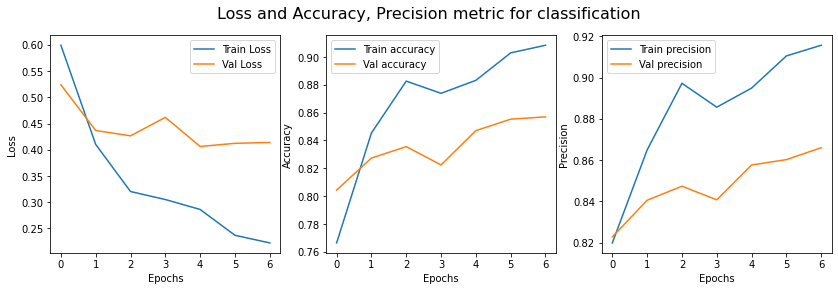

In [ ]:
f,ax = plt.subplots(1,3, figsize=(14, 4))
f.suptitle('Loss and Accuracy, Precision metric for classification', fontsize=16)

ax[0].plot(hist_c['loss'], label="Train Loss")
ax[0].plot(hist_c['val_loss'], label="Val Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")

ax[1].plot(hist_c['accuracy'], label="Train accuracy")
ax[1].plot(hist_c['val_accuracy'], label="Val accuracy")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")

ax[2].plot(hist_c['precision_3'], label="Train precision")
ax[2].plot(hist_c['val_precision_3'], label="Val precision")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("Precision")


ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.show()

**Inference**
- We can observe that the loss is decreasing and the accuracy and precision are increasing
- We getting accuracy of 85.3 % with this model

## 3. Full UNET Implementation with Data augmentation and Regularization in UNET

- The UNET architecture shown in this figure is implemented in this part
- This is a big UNET architecture since it contains much more parameters than the UNET we used before. 

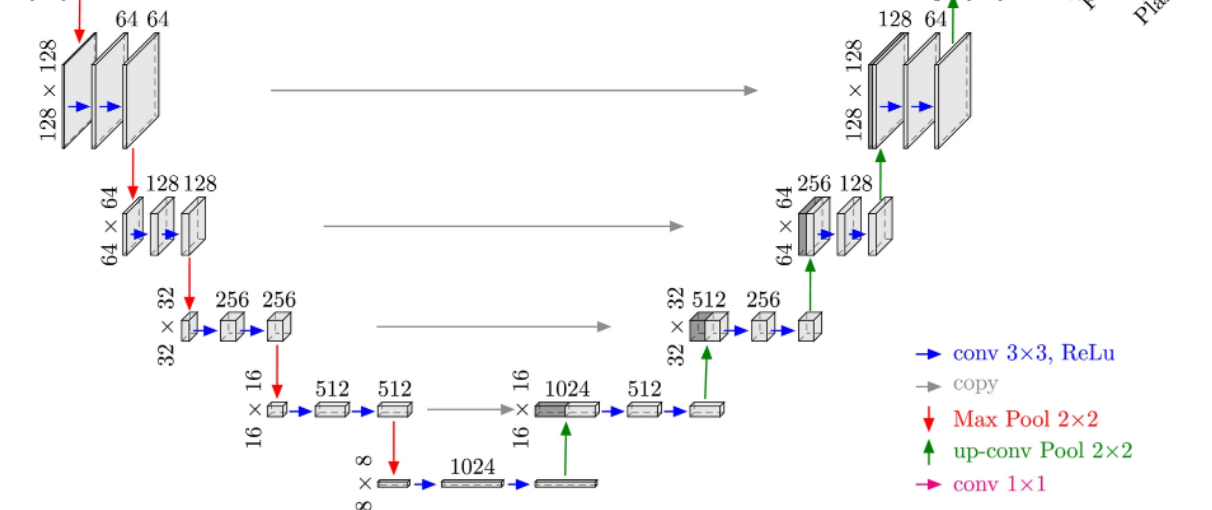

Modifications
- In between the layers we have used BatchNormalisation for regularization
- We also have used the data augmentation which will be described in the cell below

In [ ]:
image_datagen = ImageDataGenerator(rescale = 1/255.0, horizontal_flip=True,brightness_range=(0.9,1.1),
                                   zoom_range=[.9,1.1],
                                   fill_mode='nearest')
#mask_datagen = ImageDataGenerator(rescale = 1/255.0, horizontal_flip=True,)
image_datagen_no = ImageDataGenerator(rescale = 1/255.0)
#mask_datagen_no = ImageDataGenerator(rescale = 1/255.0)

train_imagegen = image_datagen.flow_from_directory('/content/drive/MyDrive/Brain_tumor_ai_2_project/AI-2-Project-Brain-Tumor-Segmentation-Dataset/data/train/scan', target_size=(128, 128), 
                                  color_mode='grayscale', class_mode=None,
                                  batch_size=16, seed=seed, shuffle=False)
train_maskgen = image_datagen.flow_from_directory('/content/drive/MyDrive/Brain_tumor_ai_2_project/AI-2-Project-Brain-Tumor-Segmentation-Dataset/data/train/mask', target_size=(128, 128), 
                                  color_mode='grayscale', class_mode=None,
                                  batch_size=16, seed=seed, shuffle=False)
val_imagegen = image_datagen_no.flow_from_directory('/content/drive/MyDrive/Brain_tumor_ai_2_project/AI-2-Project-Brain-Tumor-Segmentation-Dataset/data/val/scan', target_size=(128, 128), 
                                  color_mode='grayscale', class_mode=None,
                                  batch_size=16, seed=seed, shuffle=False)
val_maskgen = image_datagen_no.flow_from_directory('/content/drive/MyDrive/Brain_tumor_ai_2_project/AI-2-Project-Brain-Tumor-Segmentation-Dataset/data/val/mask', target_size=(128, 128), 
                                  color_mode='grayscale', class_mode=None,
                                  batch_size=16, seed=seed, shuffle=False)
test_imagegen = image_datagen_no.flow_from_directory('/content/drive/MyDrive/Brain_tumor_ai_2_project/AI-2-Project-Brain-Tumor-Segmentation-Dataset/data/test/scan', target_size=(128, 128), 
                                  color_mode='grayscale', class_mode=None,
                                  batch_size=16, seed=seed, shuffle=False)
test_maskgen = image_datagen_no.flow_from_directory('/content/drive/MyDrive/Brain_tumor_ai_2_project/AI-2-Project-Brain-Tumor-Segmentation-Dataset/data/test/mask', target_size=(128, 128), 
                                  color_mode='grayscale', class_mode=None,
                                  batch_size=16, seed=seed, shuffle=False)



Found 1838 images belonging to 1 classes.
Found 1838 images belonging to 1 classes.
Found 613 images belonging to 1 classes.
Found 613 images belonging to 1 classes.
Found 613 images belonging to 1 classes.
Found 613 images belonging to 1 classes.


In [ ]:

IMG_DIM = (128,128,1)

def blocks_convolve( input_tensor, n_filters, kernel_size = (3,3), name="downsample"):
  "Add 2 conv layer"
  x = Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal', 
             padding='same',activation="relu", name=name+'_1')(input_tensor)
  
  x = Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal', 
             padding='same',activation="relu",name=name+'_2')(x)
  return x
  

inputs = Input( shape=IMG_DIM )

down1 = blocks_convolve( inputs, 64, name="downsample1")
pool1 = MaxPooling2D( pool_size=(2,2), strides=(2,2))(down1)
pool1 = BatchNormalization(momentum=0.8)(pool1)


down2 = blocks_convolve( pool1, 128, name="downsample2_1" )
pool2 = MaxPooling2D(pool_size=(2,2), strides=(2,2) )(down2)
pool2 = BatchNormalization(momentum=0.8)(pool2)


down3 = blocks_convolve( pool2, 256, name="downsample3_1")
pool3 = MaxPooling2D(pool_size=(2,2), strides=(2,2) )(down3)
pool3 = BatchNormalization(momentum=0.8)(pool3)


down4 = blocks_convolve(pool3,512, name="downsample4_1")
pool4 = MaxPooling2D(pool_size=(2,2), strides=(2,2) )(down4)
pool4 = BatchNormalization(momentum=0.8)(pool4)

down5 = blocks_convolve(pool4,512, name="downsample5_1")

up1 = Conv2DTranspose(512, (3, 3), strides = (2, 2), padding = 'same')(down5)
up1 = concatenate([up1,down4])

conv1 = blocks_convolve(up1, 512, name="upsample1")

up2 = Conv2DTranspose(256, (3, 3), strides = (2, 2), padding = 'same')(conv1)
up2 = concatenate([up2,down3])

conv2 = blocks_convolve(up2, 256, name="upsample2")

up3 = Conv2DTranspose(128, (3, 3), strides = (2, 2), padding = 'same')(conv2)
up3 = concatenate([up3,down2])

conv3 = blocks_convolve(up3, 128, name="upsample3")

up4 = Conv2DTranspose(64, (3, 3), strides = (2, 2), padding = 'same')(conv3)
up4 = concatenate([up4,down1])

conv4 = blocks_convolve(up4,64, name="upsample4")

output = Conv2D(1, (1,1), name="outputput", activation='sigmoid')(conv4)

model_seg = Model( inputs = inputs, outputs = output )
model_seg.summary()

Model: "model_40"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 downsample1_1 (Conv2D)         (None, 128, 128, 64  640         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 downsample1_2 (Conv2D)         (None, 128, 128, 64  36928       ['downsample1_1[0][0]']          
                                )                                                          

- Total number of parameters in this UNET architecture is 22,718,529.
- We have used different callbacks 

In [ ]:
model_seg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
             loss=focal_dice_crosse, metrics=['accuracy',mean_iou])

In [ ]:
checkpoint  = ModelCheckpoint('best_model.h5', save_best_only=True, 
                                    monitor='val_loss', mode='min', verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)
lr = ReduceLROnPlateau(patience=4, verbose=2, monitor='val_loss',min_lr=1e-4, mode='min', restore_best_weights=True)

callback = [checkpoint, early_stop, lr]

history = model_seg.fit(zip(train_imagegen,train_maskgen), epochs=100, steps_per_epoch = 114, 
            validation_data= zip(val_imagegen, val_maskgen), validation_steps=38,validation_batch_size=16,
             workers=-1,
            use_multiprocessing=True, callbacks= callback)





Epoch 1/100
114/114 [==============================] - ETA: 0s - loss: 0.9372 - accuracy: 0.9711 - mean_iou: 0.5864
Epoch 1: val_loss improved from inf to 1.01636, saving model to best_model.h5
114/114 [==============================] - 48s 401ms/step - loss: 0.9372 - accuracy: 0.9711 - mean_iou: 0.5864 - val_loss: 1.0164 - val_accuracy: 0.9819 - val_mean_iou: 0.5404 - lr: 0.0010
Epoch 2/100
114/114 [==============================] - ETA: 0s - loss: 0.7006 - accuracy: 0.9748 - mean_iou: 0.7085
Epoch 2: val_loss improved from 1.01636 to 0.82741, saving model to best_model.h5
114/114 [==============================] - 45s 395ms/step - loss: 0.7006 - accuracy: 0.9748 - mean_iou: 0.7085 - val_loss: 0.8274 - val_accuracy: 0.9826 - val_mean_iou: 0.5976 - lr: 0.0010
Epoch 3/100
114/114 [==============================] - ETA: 0s - loss: 0.6388 - accuracy: 0.9760 - mean_iou: 0.7359
Epoch 3: val_loss did not improve from 0.82741
114/114 [==============================] - 44s 387ms/step - loss: 0

In [ ]:
model_seg.save("model_final.h5")

Plotting the Loss and Mean IOU metric since accuracy isn't important here because of pixel-wise class imbalance

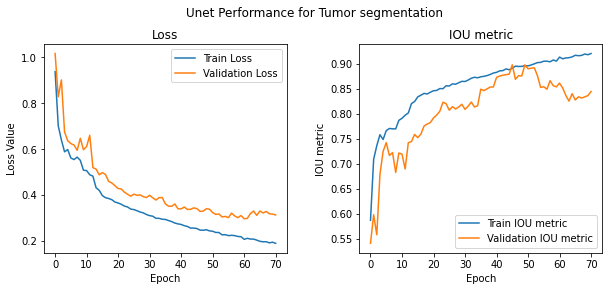

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
t = f.suptitle('Unet Performance for Tumor segmentation', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
epoch_list = history.epoch


ax1.plot(epoch_list, history.history['loss'], label='Train Loss')
ax1.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax1.set_ylabel('Loss Value');ax1.set_xlabel('Epoch');ax1.set_title('Loss')
ax1.legend(loc="best");


ax2.plot(epoch_list, history.history['mean_iou'], label='Train IOU metric')
ax2.plot(epoch_list, history.history['val_mean_iou'], label='Validation IOU metric')
ax2.set_ylabel('IOU metric');ax2.set_xlabel('Epoch');ax2.set_title('IOU metric')
ax2.legend(loc="best");


**Inference**
- We can observe that our mean iou for the model is around 0.84 by minimising the loss function which is the combination of three loss functions as mentioned above
- But we should Check the saliency maps to see whether the model is taking the information of tumor into consideration to segment the image. 

**Saliency Maps**
- We are doing the saliency maps to see the model is taking the information of the tumor or not

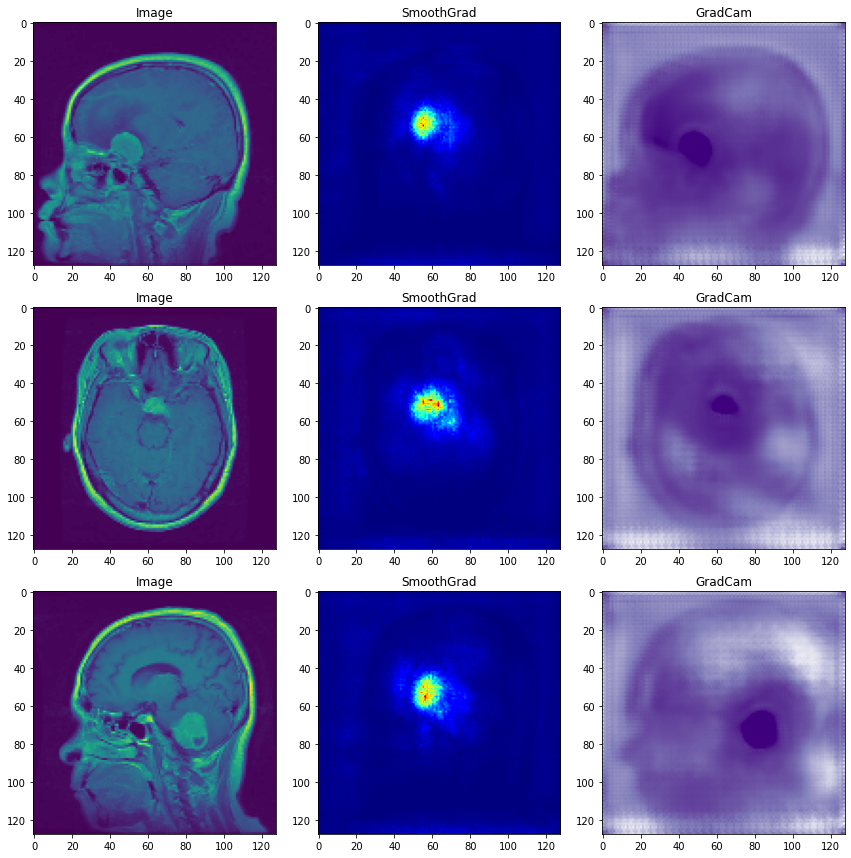

In [ ]:
f, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
image_titles = ["Image", "SmoothGrad", "GradCam"]
plt.tight_layout()


for i in range(3):
  bat = random.randint(0,36)
  ix = random.randint(0,15)
  saliency = Saliency(model_seg, 
                      model_modifier=replace2linear,
                      clone=True)
  def score_function(out=model_seg.predict(val_imagegen[batch][img].reshape(1,128,128,1)),label=val_maskgen[batch][img]):
  
    return mean_iou(out, label)
  
  saliency_map = saliency(score_function, val_imagegen[bat][ix].reshape(1,128,128,1),
                          smooth_samples =20,
                          smooth_noise= 0.20)
  gradcam = Gradcam(model_seg,
                    model_modifier=replace2linear,
                    clone=True)

  # Generate heatmap with GradCAM
  cam = gradcam(score_function,
                val_imagegen[bat][ix].reshape(1,128,128,1),
                penultimate_layer=-1)
  
  heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)

  ax[i][0].set_title(image_titles[0], fontsize=12)
  ax[i][0].imshow(val_imagegen[bat][ix].reshape(1,128,128,1).reshape(128,128))
  ax[i][0].axis('on')
  
  ax[i][1].set_title(image_titles[1], fontsize=12)
  ax[i][1].imshow(saliency_map.squeeze(), cmap='jet')
  ax[i][1].axis('on')
  
  ax[i][2].set_title(image_titles[2], fontsize=12)
  ax[i][2].imshow(val_imagegen[bat][ix].reshape(1,128,128,1).reshape(128,128))
  # Here, 1-cam is used cause the score function is mean_iou which is like accuracy not loss
  ax[i][2].imshow(1-cam.squeeze(), cmap='Purples')
  
  ax[i][2].axis('on')

plt.show()


**Inference**
- From this figure of smooth grad and grad cam, we can clearly observe that the autoencoder model is segmenting based on the tumor information

**Observing mean iou to see how the mean iou effects image segmentation**

In [ ]:
mean_iou_list = []
images = []
for batch in range(38):
  for img in range(16):
    y_true = val_maskgen[batch][img]
    y_pred = model_seg.predict(val_imagegen[batch][img].reshape(1,128,128,1))
    score_iou = mean_iou(y_true, y_pred)
    mean_iou_list.append(score_iou.numpy()) 
    images.append((batch, img))                         


In [ ]:
index = np.argsort(mean_iou_list)


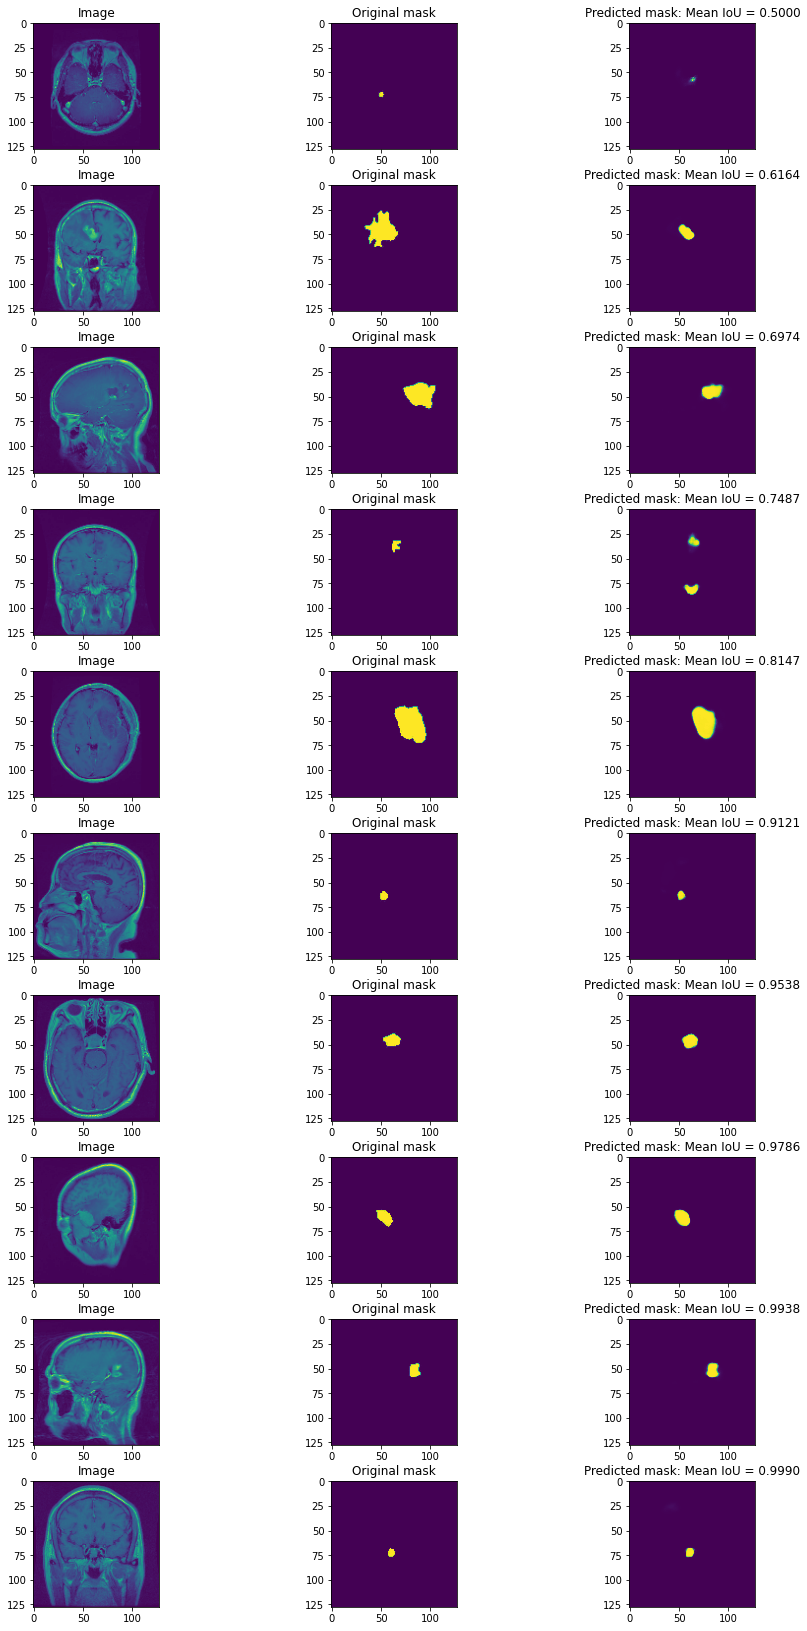

In [ ]:
buckets = [55, 90, 106, 126, 156, 255, 356, 455, 555, 607]
figure, axis = plt.subplots(10, 3, figsize = (20, 20))

plt.tight_layout()
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.7, 
                    top=1.2)

for i in range (10):
    axis[i][0].imshow(val_imagegen[images[index[buckets[i]]][0]][images[index[buckets[i]]][1]].reshape(128,128))
    axis[i][0].set_title("Image", fontsize = 12)
    
    axis[i][1].imshow(val_maskgen[images[index[buckets[i]]][0]][images[index[buckets[i]]][1]].reshape(128,128))
    axis[i][1].set_title("Original mask", fontsize = 12)
    axis[i][2].imshow(model_seg.predict(val_imagegen[images[index[buckets[i]]][0]][images[index[buckets[i]]][1]].reshape(1,128,128,1)).reshape(128,128))
    axis[i][2].set_title(f"Predicted mask: Mean IoU = {mean_iou_list[index[buckets[i]]]:.4f}", fontsize = 12)
      

plt.show()
  

**Inference**
- From the plot above, we can get a idea about how the images are segmented
- If the mean iou is high then the segmentation is good as the mask given in the data
- If the mean iou is low then the segmentation is bad compared to the mask given

 **Classification** 
- Since, we want to do the classification based on the tumor information we are trying to do the classification using the encoder layers of the UNET till the latent space and build the classification model after that. 

**Hypothesis**
- Since, we are segmenting the image to the same space i.e., (128, 128) to (128, 128) we assume that the information about location of the tumor is preserved in the segmentation model and it will help in the classification better 

In [ ]:
train_imagegen = image_datagen.flow_from_directory('/content/drive/MyDrive/Brain_tumor_ai_2_project/AI-2-Project-Brain-Tumor-Segmentation-Dataset/classification/train', 
                                  target_size=(128, 128), 
                                  color_mode='grayscale', class_mode='categorical',
                                  batch_size=16, seed=seed, shuffle=True)
val_imagegen = image_datagen_no.flow_from_directory('/content/drive/MyDrive/Brain_tumor_ai_2_project/AI-2-Project-Brain-Tumor-Segmentation-Dataset/classification/validation/', 
                                                 target_size=(128, 128), 
                                  color_mode='grayscale', class_mode='categorical',
                                  batch_size=16, seed=seed, shuffle=True)
test_imagegen = image_datagen_no.flow_from_directory('/content/drive/MyDrive/Brain_tumor_ai_2_project/AI-2-Project-Brain-Tumor-Segmentation-Dataset/classification/test/', 
                                                  target_size=(128, 128), 
                                  color_mode='grayscale', class_mode='categorical',
                                  batch_size=16, seed=seed, shuffle=True)

Found 1849 images belonging to 3 classes.
Found 613 images belonging to 3 classes.
Found 612 images belonging to 3 classes.


- In building the classification model first we used the encoder layers upto latent space of the UNET model above and applied the same data augmentation to the data as used in the above segmentation model

In [ ]:
classification_input = Input(shape=(128, 128, 1))
classification_model = classification_input
for layer in model_seg.layers[1:19]:
    layer.trainable = False
    classification_model = layer(classification_model)

flat = Flatten()(classification_model)
dense1 = Dense(2048, activation='relu')(flat) 
drop1 = Dropout(0.2)(dense1)
dense2 = Dense(1024, activation='relu')(drop1)
drop2 = Dropout(0.2)(dense2)
dense3 = Dense(512, activation='relu')(drop2)
drop3 = Dropout(0.2)(dense3)
dense4 = Dense(64, activation='relu')(drop3)
final = Dense(3, activation='softmax')(dense2)


classification_model = Model(inputs = classification_input, outputs = final)
classification_model.compile(optimizer = Adam(), loss=CategoricalCrossentropy(), metrics =['accuracy',tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [ ]:
classification_model.summary()

Model: "model_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 128, 128, 1)]     0         
                                                                 
 downsample1_1 (Conv2D)      (None, 128, 128, 64)      640       
                                                                 
 downsample1_2 (Conv2D)      (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                                 
                                                                 
 downsample2_1_1 (Conv2D)    (None, 64, 64, 128)       738

In [ ]:
checkpoint_class  = ModelCheckpoint('model_best_class_checkpoint.h5', save_best_only=True, 
                                    monitor='val_loss', mode='min', verbose=1)
early_stop_class = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)
lr_class = ReduceLROnPlateau(patience=4, verbose=2, monitor='val_loss',min_lr=1e-4, mode='min', restore_best_weights=True)

callback_class = [early_stop_class, lr_class, checkpoint_class]


In [ ]:
class_history = classification_model.fit(train_imagegen, epochs=100, steps_per_epoch = 114, 
            validation_data= val_imagegen, validation_steps=38,validation_batch_size=16, workers=-1,
            use_multiprocessing=True, callbacks = callback_class)

Epoch 1/100
114/114 [==============================] - ETA: 0s - loss: 2.3104 - accuracy: 0.6968 - recall_5: 0.6802 - precision_5: 0.7059
Epoch 1: val_loss improved from inf to 0.63375, saving model to model_best_class_checkpoint.h5
114/114 [==============================] - 20s 164ms/step - loss: 2.3104 - accuracy: 0.6968 - recall_5: 0.6802 - precision_5: 0.7059 - val_loss: 0.6338 - val_accuracy: 0.7911 - val_recall_5: 0.7845 - val_precision_5: 0.8017 - lr: 0.0010
Epoch 2/100
114/114 [==============================] - ETA: 0s - loss: 0.7487 - accuracy: 0.7733 - recall_5: 0.7578 - precision_5: 0.7837
Epoch 2: val_loss improved from 0.63375 to 0.42747, saving model to model_best_class_checkpoint.h5
114/114 [==============================] - 20s 171ms/step - loss: 0.7487 - accuracy: 0.7733 - recall_5: 0.7578 - precision_5: 0.7837 - val_loss: 0.4275 - val_accuracy: 0.8306 - val_recall_5: 0.8125 - val_precision_5: 0.8387 - lr: 0.0010
Epoch 3/100
114/114 [==============================] - E

**The plots of accuracy, precision and loss**

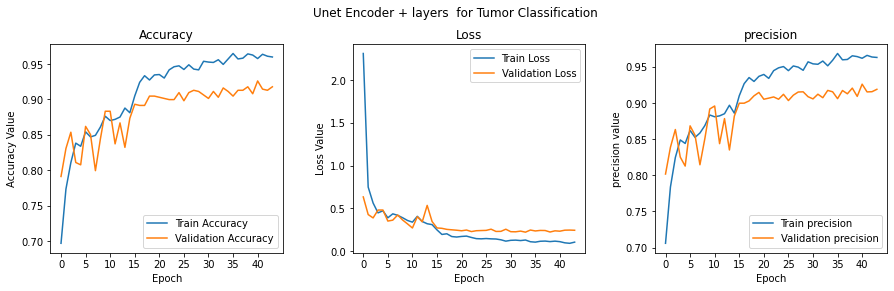

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
t = f.suptitle('Unet Encoder + layers  for Tumor Classification', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
epoch_list = class_history.epoch

ax1.plot(epoch_list, class_history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, class_history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epoch_list[-1], 5))
ax1.set_ylabel('Accuracy Value');ax1.set_xlabel('Epoch');ax1.set_title('Accuracy')
ax1.legend(loc="best");

ax2.plot(epoch_list, class_history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, class_history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epoch_list[-1], 5))
ax2.set_ylabel('Loss Value');ax2.set_xlabel('Epoch');ax2.set_title('Loss')
ax2.legend(loc="best");

ax3.plot(epoch_list, class_history.history['precision_5'], label='Train precision')
ax3.plot(epoch_list, class_history.history['val_precision_5'], label='Validation precision')
ax3.set_xticks(np.arange(0, epoch_list[-1], 5))
ax3.set_ylabel('precision value');ax3.set_xlabel('Epoch');ax3.set_title('precision')
ax3.legend(loc="best");





**Inference**
- We can observe that the loss is decreasing and the precision and accuracy is increasing

Evaluating the model

In [ ]:
classification_model.evaluate(test_imagegen)


39/39 [==============================] - 2s 49ms/step - loss: 0.2549 - accuracy: 0.9150 - recall_5: 0.9085 - precision_5: 0.9160


[0.25488749146461487,
 0.915032684803009,
 0.9084967374801636,
 0.9159802198410034]

- We got an accuracy of 91.59 % from this model

Visualizing Predictions

In [ ]:
cancer_dict = {0:'glioma', 1:'meningioma', 2:'pituitary tumor'}

3 25
8 12
0 11
10 32
13 17


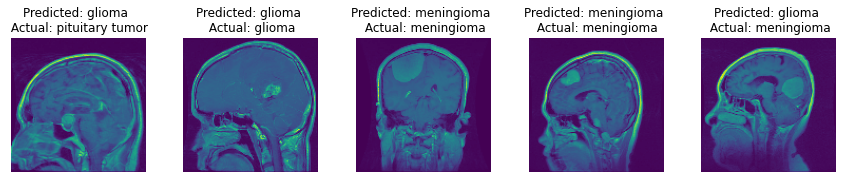

In [ ]:
num_images = 5

fig, ax = plt.subplots(1,num_images,figsize=(12,12))
for i in range(num_images):
    batch = random.randint(0,36)
    idx = random.randint(0,15)
    print(idx, batch)
    prediction = classification_model.predict(test_imagegen)
        
    pred= cancer_dict[int(np.argmax(prediction[batch*16 + idx]))]
    
    img = test_imagegen[batch][0][idx].reshape(128, 128)
    
    ax[i].imshow(img)
    ax[i].set_title(f'Predicted: {pred} \n Actual: {cancer_dict[int(np.argmax(test_imagegen[batch][1][idx]))]}')
    ax[i].axis('off')

plt.tight_layout()   

- We can observe the prediction of the tumors from the mri scan images by the model

## Tranfer Learning
- We tried to use the UNET which is available in the keras segmentation models
- This UNET had been trained on Imagenet dataset for the segmentation

In [ ]:
image_datagen = ImageDataGenerator(rescale = 1/255)
mask_datagen = ImageDataGenerator(rescale = 1/255)

train_imagegen = image_datagen.flow_from_directory('/content/drive/MyDrive/Brain_tumor_ai_2_project/AI-2-Project-Brain-Tumor-Segmentation-Dataset/data/train/scan', target_size=(512, 512), 
                                   class_mode=None,
                                  batch_size=16, seed=seed, shuffle=False)
train_maskgen = mask_datagen.flow_from_directory('/content/drive/MyDrive/Brain_tumor_ai_2_project/AI-2-Project-Brain-Tumor-Segmentation-Dataset/data/train/mask', target_size=(512, 512), 
                                   class_mode=None,
                                  batch_size=16, seed=seed, shuffle=False)
val_imagegen = image_datagen.flow_from_directory('/content/drive/MyDrive/Brain_tumor_ai_2_project/AI-2-Project-Brain-Tumor-Segmentation-Dataset/data/val/scan', target_size=(512, 512), 
                                   class_mode=None,
                                  batch_size=16, seed=seed, shuffle=False)
val_maskgen = mask_datagen.flow_from_directory('/content/drive/MyDrive/Brain_tumor_ai_2_project/AI-2-Project-Brain-Tumor-Segmentation-Dataset/data/val/mask', target_size=(512, 512), 
                                   class_mode=None,
                                  batch_size=16, seed=seed, shuffle=False)
test_imagegen = image_datagen.flow_from_directory('/content/drive/MyDrive/Brain_tumor_ai_2_project/AI-2-Project-Brain-Tumor-Segmentation-Dataset/data/test/scan', target_size=(512, 512), 
                                   class_mode=None,
                                  batch_size=16, seed=seed, shuffle=False)
test_maskgen = mask_datagen.flow_from_directory('/content/drive/MyDrive/Brain_tumor_ai_2_project/AI-2-Project-Brain-Tumor-Segmentation-Dataset/data/test/mask', target_size=(512, 512), 
                                   class_mode=None,
                                  batch_size=16, seed=seed, shuffle=False)



Found 1838 images belonging to 1 classes.
Found 1838 images belonging to 1 classes.
Found 613 images belonging to 1 classes.
Found 613 images belonging to 1 classes.
Found 613 images belonging to 1 classes.
Found 613 images belonging to 1 classes.


Transfer learning model using U net and using Resnet as backbone
- First we need to install this to get the UNET in keras

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-tgbtg7zm
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-tgbtg7zm
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 50 kB 6.0 MB/s 
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33810 sha256=f108060c37b36a7535448a1ffd926427012887f8b6ef683912b77d120938b4e0
  Stored in directory: /tmp/pip-ephem-wheel-cache-d06a660a/wheels/02/cd/18/61c0bbb8766acfec68f9d20618886b7b38dfeeb95865b6ba00
Successfully built segmentation-models


- It's important to set the framework otherwise it will give the error

In [ ]:
import segmentation_models as sm

sm.set_framework('tf.keras')

sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [ ]:
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

In [ ]:
BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)

# preprocess input
train_imagegen = preprocess_input(train_imagegen)
val_imagegen = preprocess_input(val_imagegen)

# define model
model = Unet(BACKBONE, encoder_weights=None, classes = 1, activation='sigmoid', input_shape=(512, 512, 3))
model.compile(optimizer = Adam(learning_rate=1e-3), loss= sm.losses.BinaryFocalLoss(alpha=0.25, gamma=2.0)+sm.losses.BinaryCELoss()+sm.losses.DiceLoss(), metrics=[iou_score])


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 512, 512, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 518, 518, 3)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)                 (None, 256, 256, 64  9408        ['zero_padding2d[0][0]']   

In [ ]:
model.fit(zip(train_imagegen,train_maskgen), epochs=100, steps_per_epoch = 114, 
            validation_data= zip(val_imagegen, val_maskgen), validation_steps=38,validation_batch_size=16, workers=-1,
            use_multiprocessing=True)

Epoch 1/100
114/114 [==============================] - 1813s 16s/step - loss: 1.1073 - iou_score: 0.0378 - val_loss: 83.0926 - val_iou_score: 1.6731e-10
Epoch 2/100
114/114 [==============================] - 158s 1s/step - loss: 0.8427 - iou_score: 0.1573 - val_loss: 61.8776 - val_iou_score: 0.0202
Epoch 3/100
114/114 [==============================] - 135s 1s/step - loss: 0.7267 - iou_score: 0.2452 - val_loss: 22.5625 - val_iou_score: 0.0223
Epoch 4/100
114/114 [==============================] - 135s 1s/step - loss: 0.6996 - iou_score: 0.2712 - val_loss: 1.1871 - val_iou_score: 0.0819
Epoch 5/100
114/114 [==============================] - 135s 1s/step - loss: 0.6794 - iou_score: 0.2877 - val_loss: 2.0162 - val_iou_score: 0.0549
Epoch 6/100
114/114 [==============================] - 135s 1s/step - loss: 0.6861 - iou_score: 0.2822 - val_loss: 0.9262 - val_iou_score: 0.1531
Epoch 7/100
114/114 [==============================] - 135s 1s/step - loss: 0.6639 - iou_score: 0.3027 - val_loss: 

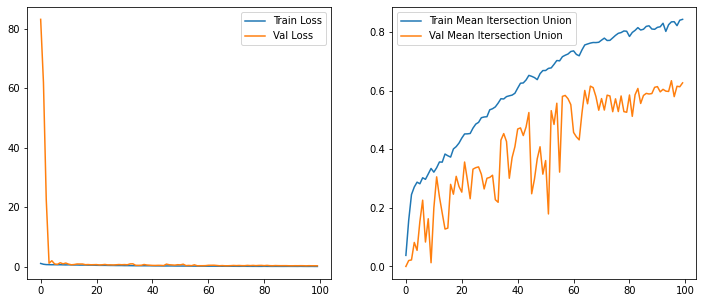

In [ ]:
f,ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(model.history.history['loss'], label="Train Loss")
ax[0].plot(model.history.history['val_loss'], label="Val Loss")



ax[1].plot(model.history.history['iou_score'], label="Train Mean IoU")
ax[1].plot(model.history.history['val_iou_score'], label="Val Mean IoU")


ax[0].legend()
ax[1].legend()
plt.show()

**Inference**
- We used the weights from this model but the mean iou was very less that's why we trained it with our dataset without using the weights from before
- Since, the mean iou for this is only 0.64 approximately which is lower than the models we did before we didn't proceed with this model for classification
- We think we are not getting good results because the model might be trained with the images from the Imagenet which is kind of pixel-wise balanced comapared to our tumor in the image
- So they may have not fine tuned it for that purpose but we need to check more about this and train for more epochs

## Simple UNET model with different data
- This is the same simple UNET model which has been implemented before
- But here we are shuffling the data using patient ID to check whether the model is predicting differently

In [ ]:
# we create two instances with the same arguments 
data_gen_args = dict(rescale = 1/255) 
image_datagen = ImageDataGenerator(**data_gen_args) 
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods seed = 1 
#image_datagen.fit(images, augment=True, seed=seed) 
#mask_datagen.fit(masks, augment=True, seed=seed)

train_imagegen = image_datagen.flow_from_directory('data/scan/train', target_size=(512, 512), 
                                  color_mode='grayscale', class_mode=None,
                                  batch_size=16, seed=seed, shuffle=False)
train_maskgen = mask_datagen.flow_from_directory('data/mask/train', target_size=(512, 512), 
                                  color_mode='grayscale', class_mode=None,
                                  batch_size=16, seed=seed, shuffle=False)
val_imagegen = image_datagen.flow_from_directory('data/scan/validation', target_size=(512, 512), 
                                  color_mode='grayscale', class_mode=None,
                                  batch_size=16, seed=seed, shuffle=False)
val_maskgen = mask_datagen.flow_from_directory('data/mask/validation', target_size=(512, 512), 
                                  color_mode='grayscale', class_mode=None,
                                  batch_size=16, seed=seed, shuffle=False)
test_imagegen = image_datagen.flow_from_directory('data/scan/test', target_size=(512, 512), 
                                  color_mode='grayscale', class_mode=None,
                                  batch_size=16, seed=seed, shuffle=False)
test_maskgen = mask_datagen.flow_from_directory('data/mask/test', target_size=(512, 512), 
                                  color_mode='grayscale', class_mode=None,
                                  batch_size=16, seed=seed, shuffle=False)

# combine generators into one which yields image and masks 
train_generator = zip(train_imagegen, train_maskgen)
val_generator = zip(val_imagegen, val_maskgen)
test_generator = zip(test_imagegen, test_maskgen)

Found 1815 images belonging to 1 classes.
Found 1815 images belonging to 1 classes.
Found 644 images belonging to 1 classes.
Found 644 images belonging to 1 classes.
Found 605 images belonging to 1 classes.
Found 605 images belonging to 1 classes.


In [ ]:
# model-2 inspired by u-net

def convolution(inputs, filters = 32):
    conv1 = Conv2D(filters, kernel_size=(3,3), padding="same", strides=(1,1))(inputs)
    #batch_norm1 = BatchNormalization()(conv1)
    relu1 = ReLU()(conv1)
    
    conv2 = Conv2D(filters, kernel_size=(3,3), padding="same", strides=(1,1))(relu1)
    #batch_norm2 = BatchNormalization()(conv2)
    relu2 = ReLU()(conv2)
    
    return relu2
    
def encoder(inputs, filters = 32):
    cv = convolution(inputs, filters)
    maxpool = MaxPooling2D(pool_size=(4,4))(cv)
    return (cv,maxpool)

def decoder(inputs, skips , filters = 32):
    cv1 = Conv2DTranspose(filters, kernel_size=(3,3), padding="same", strides=(4,4))(inputs)
    concate = Concatenate()([cv1, skips])
    cv2 = convolution(concate, filters)
    return cv2

def U_Net(image_size):
    input1 = Input(image_size)
    
    # Construct the encoder blocks
    skip1, encoder_1 = encoder(input1, 16)
    skip2, encoder_2 = encoder(encoder_1, 16*2)
    skip3, encoder_3 = encoder(encoder_2, 16*4)
    skip4, encoder_4 = encoder(encoder_3, 16*8)
    
    # Preparing the next block
    conv_block = convolution(encoder_4, 16*16)
    
    # Construct the decoder blocks
    decoder_1 = decoder(conv_block, skip4, 16*8)
    decoder_2 = decoder(decoder_1, skip3, 16*4)
    decoder_3 = decoder(decoder_2, skip2, 16*2)
    decoder_4 = decoder(decoder_3, skip1, 16)
    
    out = Conv2D(1, 1, padding="same", activation="sigmoid")(decoder_4)

    model = Model(input1, out)
    return model

model = U_Net((512,512,1))
model.compile(optimizer = Adam(learning_rate=1e-3), loss=focal_dice_crosse, metrics = [mean_iou, 'accuracy'])

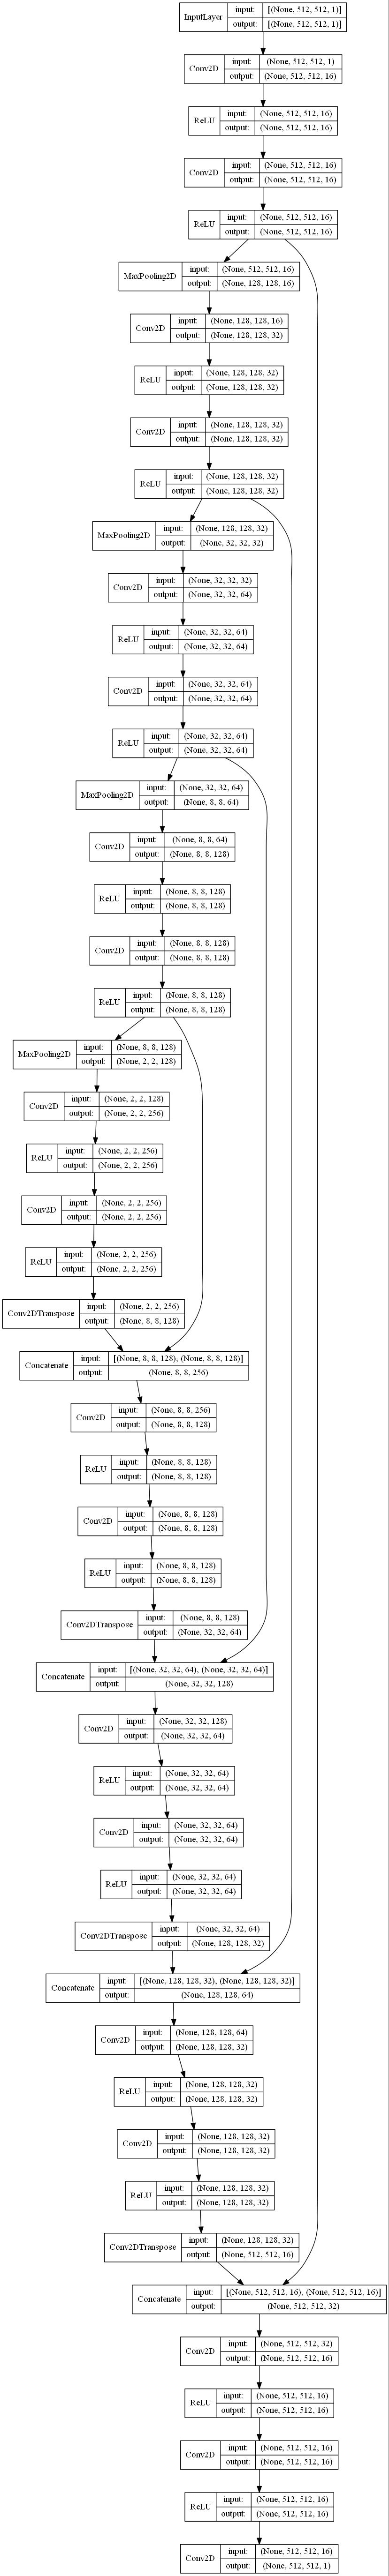

In [ ]:
tf.keras.utils.plot_model(model, to_file='unet-patientWiseData.jpg', show_shapes=True, show_layer_names=False, )

In [ ]:
history = model.fit(train_generator, epochs=50, steps_per_epoch = 114, 
            validation_data= val_generator, validation_steps=38,validation_batch_size=16, workers=-1,
            use_multiprocessing=True, shuffle=True)
hist = history.history

Epoch 1/50
114/114 [==============================] - 83s 712ms/step - loss: 1.1290 - mean_iou: 0.5008 - accuracy: 0.9721 - val_loss: 1.7358 - val_mean_iou: 0.5443 - val_accuracy: 0.9765
Epoch 2/50
114/114 [==============================] - 84s 735ms/step - loss: 0.9518 - mean_iou: 0.5649 - accuracy: 0.9715 - val_loss: 1.8956 - val_mean_iou: 0.5220 - val_accuracy: 0.9809
Epoch 3/50
114/114 [==============================] - 84s 739ms/step - loss: 0.9404 - mean_iou: 0.5687 - accuracy: 0.9759 - val_loss: 1.0081 - val_mean_iou: 0.5656 - val_accuracy: 0.9769
Epoch 4/50
114/114 [==============================] - 84s 741ms/step - loss: 0.8877 - mean_iou: 0.6526 - accuracy: 0.9678 - val_loss: 1.3160 - val_mean_iou: 0.5223 - val_accuracy: 0.9823
Epoch 5/50
114/114 [==============================] - 84s 736ms/step - loss: 0.9008 - mean_iou: 0.6256 - accuracy: 0.9765 - val_loss: 1.3206 - val_mean_iou: 0.5722 - val_accuracy: 0.9828
Epoch 6/50
114/114 [==============================] - 84s 736ms/s

Epoch 45/50
114/114 [==============================] - 84s 736ms/step - loss: 0.3368 - mean_iou: 0.8540 - accuracy: 0.9886 - val_loss: 0.5719 - val_mean_iou: 0.7914 - val_accuracy: 0.9816
Epoch 46/50
114/114 [==============================] - 84s 735ms/step - loss: 0.3340 - mean_iou: 0.8588 - accuracy: 0.9885 - val_loss: 0.6030 - val_mean_iou: 0.8037 - val_accuracy: 0.9794
Epoch 47/50
114/114 [==============================] - 84s 736ms/step - loss: 0.3108 - mean_iou: 0.8679 - accuracy: 0.9890 - val_loss: 0.6349 - val_mean_iou: 0.8040 - val_accuracy: 0.9765
Epoch 48/50
114/114 [==============================] - 84s 737ms/step - loss: 0.3067 - mean_iou: 0.8713 - accuracy: 0.9890 - val_loss: 0.6125 - val_mean_iou: 0.8198 - val_accuracy: 0.9774
Epoch 49/50
114/114 [==============================] - 84s 735ms/step - loss: 0.2832 - mean_iou: 0.8766 - accuracy: 0.9898 - val_loss: 0.7138 - val_mean_iou: 0.8195 - val_accuracy: 0.9738
Epoch 50/50
114/114 [==============================] - 84s 7

**Plots for the loss and mean iou metric**

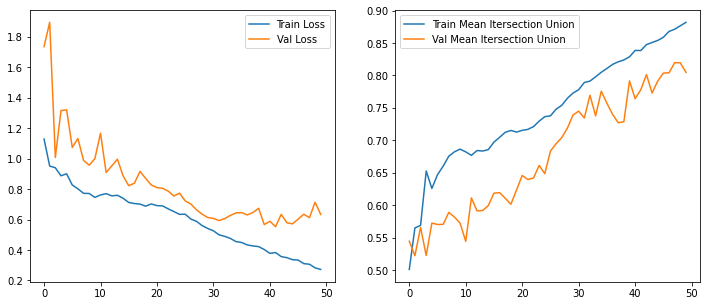

In [ ]:
f,ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(hist['loss'], label="Train Loss")
ax[0].plot(hist['val_loss'], label="Val Loss")

ax[1].plot(hist['mean_iou'], label="Train Mean Itersection Union")
ax[1].plot(hist['val_mean_iou'], label="Val Mean Itersection Union")


ax[0].legend()
ax[1].legend()
plt.show()

**Visualizing predictions from validation data**

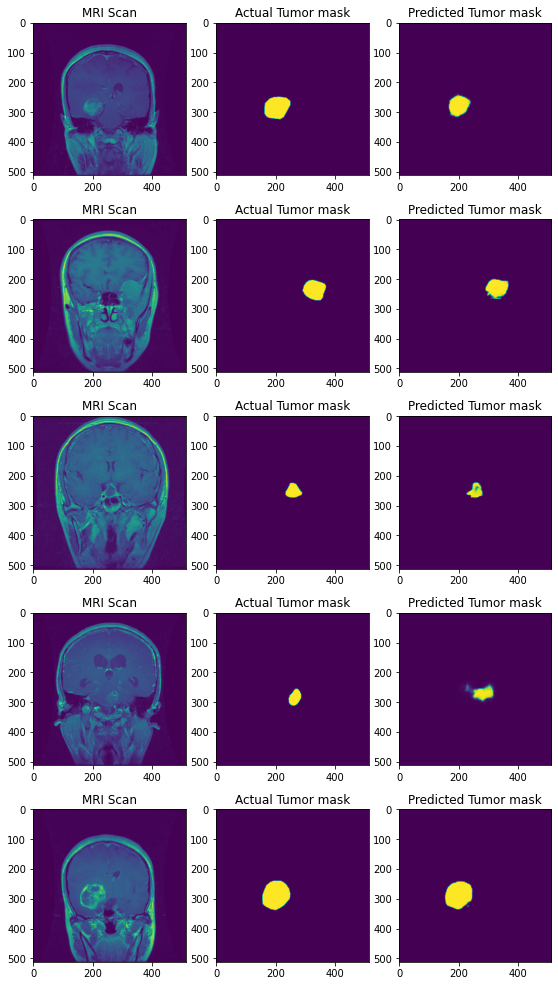

In [ ]:
f,ax = plt.subplots(5,3, figsize=(12,12))


for i in range(5):
    batch = random.randint(0,38)
    img = random.randint(0,15)
    
    ax[i][0].imshow(val_imagegen[batch][img])
    ax[i][0].set_title("MRI Scan")
    
    ax[i][1].imshow(val_maskgen[batch][img])
    ax[i][1].set_title("Actual Tumor mask")
    
    ax[i][2].imshow(model.predict(val_imagegen[batch][img].reshape(1,512,512,1)).reshape(512,512))
    ax[i][2].set_title("Predicted Tumor mask")
    
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.7, 
                    top=1.2)

plt.show()

**Visualizing predictions from the test data**

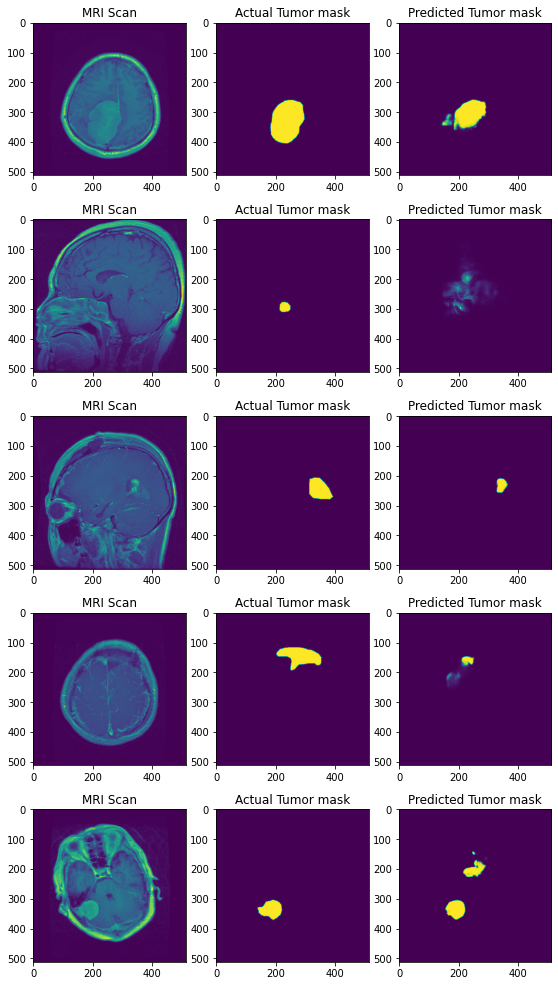

In [ ]:
f,ax = plt.subplots(5,3, figsize=(12,12))


for i in range(5):
    batch = random.randint(0,37)
    img = random.randint(0,15)
    
    ax[i][0].imshow(test_imagegen[batch][img])
    ax[i][0].set_title("MRI Scan")
    
    ax[i][1].imshow(test_maskgen[batch][img])
    ax[i][1].set_title("Actual Tumor mask")
    
    ax[i][2].imshow(model.predict(test_imagegen[batch][img].reshape(1,512,512,1)).reshape(512,512))
    ax[i][2].set_title("Predicted Tumor mask")
    
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.7, 
                    top=1.2)

plt.show()

**TSNE**
- To see how good the encoding is done

In [ ]:
class_imagegen = image_datagen.flow_from_directory('for-tsne/', target_size=(512, 512), 
                                  color_mode='grayscale', class_mode='categorical',
                                  batch_size=1500, seed=seed, shuffle=True)

Found 3064 images belonging to 3 classes.


In [ ]:
encoder_input = Input(shape=model.layers[0].input_shape[0][1:])
encoder_model = encoder_input
for layer in model.layers[1:25]:
    encoder_model = layer(encoder_model)

encoder_model = Model(inputs = encoder_input, outputs = encoder_model)

In [ ]:
tsne_out = TSNE(n_components=2, learning_rate='auto', init='pca').fit_transform(K.batch_flatten(encoder_model.predict(class_imagegen[0][0])))

D:\Programs\Anaconda\envs\tf2.8\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


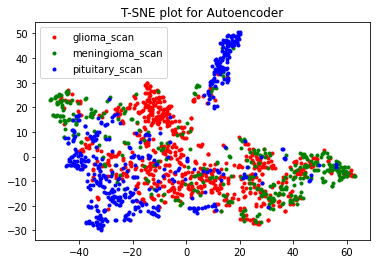

In [ ]:
idx = (class_imagegen[0][1] == 1)
sc0 = plt.scatter(tsne_out[idx[:,0],0], tsne_out[idx[:,0],1],  marker='.', color='red')
sc1 = plt.scatter(tsne_out[idx[:,1],0], tsne_out[idx[:,1],1],  marker='.', color='green')
sc2 = plt.scatter(tsne_out[idx[:,2],0], tsne_out[idx[:,2],1],  marker='.', color='blue')

plt.title("T-SNE plot for Autoencoder")
plt.legend((sc0,sc1,sc2),(class_imagegen.class_indices))
plt.show()

**Inference**
- From the plot above we can observe that the encoded layers doesn't separate the tumors clearly
- It might be because we are were using it for segmentation not for classification feature extraction

**Saliency Maps**
- To check whether the model is predicting based on the tumor region

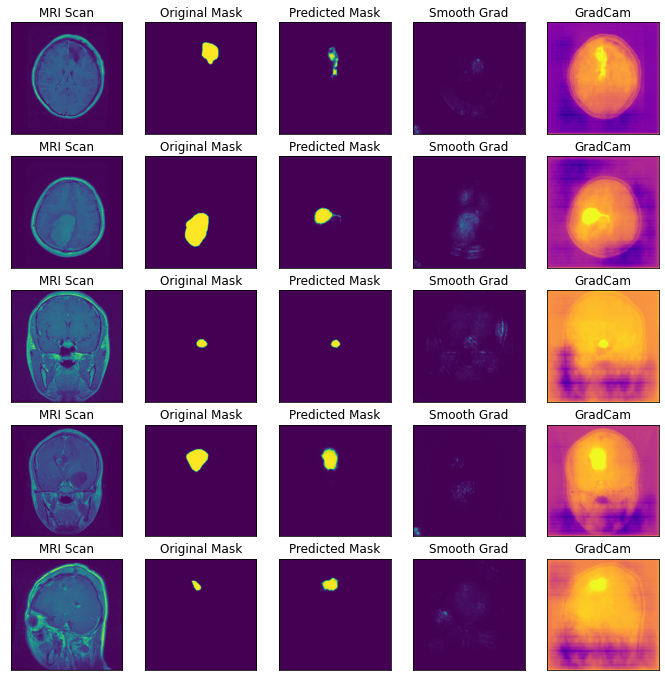

In [ ]:
def score_function_grad(output):
    return mean_iou(output, y)

def score_function(output):
    return output
f,ax = plt.subplots(5,5, figsize=(15,15))

for a in ax.ravel():
    a.set_xticks([])
    a.set_yticks([])

for i in range(5):
    
    batch = random.randint(0,37)
    img = random.randint(0,15)
    
    X = np.expand_dims(test_imagegen[batch][img], axis=0)
    y = np.expand_dims(test_maskgen[batch][img], axis=0)

    saliency = Saliency(model, 
                        model_modifier=ReplaceToLinear(),
                        clone=True)
    saliency_map = saliency(score_function, X,
                            smooth_samples =20,
                            smooth_noise= 0.20)
    cm = normalize(saliency_map)

    gradcam = Gradcam(model,
                      model_modifier=ReplaceToLinear(),
                      clone=True)

    cam = gradcam(score_function_grad,
                  X,
                  penultimate_layer=-1)
        
    
    ax[i][0].imshow(X.squeeze())
    ax[i][0].set_title("MRI Scan")
    
    ax[i][1].imshow(y.squeeze())
    ax[i][1].set_title("Original Mask")

    ax[i][2].imshow(model.predict(X).squeeze())
    ax[i][2].set_title("Predicted Mask")    

    ax[i][3].imshow(cm.squeeze(),cmap='viridis')
    ax[i][3].set_title("Smooth Grad")

    ax[i][4].imshow(1-cam.squeeze(),cmap='plasma')
    ax[i][4].set_title("GradCam")
    
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.7, 
                    top=0.7)


plt.show()

**Inference**
- Here, also we can see in gradcam that it is highlighting the tumor region and we can say that it is using that information
- We can also see that two types of data shuffling gives almost same results

# Function to Predict Tumor Region and Class
- Here, we have defined a function to segment the image and predict it's class using the model we have defined above

In [ ]:
scan_datagen1 = ImageDataGenerator(rescale = 1./255, validation_split=0.3)
mask_datagen1 = ImageDataGenerator(rescale = 1./255, validation_split=0.3)

seed=909

scan_valgen1 = scan_datagen1.flow_from_directory('/content/drive/MyDrive/Univ.ai/AI_2_Project/Scanned_images/scan', 
                                       target_size=(512, 512),
                                       batch_size = 16,
                                       color_mode='grayscale',class_mode='categorical',
                                       subset = 'validation', seed=seed, shuffle=False)


mask_valgen1 = mask_datagen1.flow_from_directory('/content/drive/MyDrive/Univ.ai/AI_2_Project/Scanned_images/mask', 
                                       target_size=(512, 512),
                                       batch_size = 16,
                                       color_mode='grayscale',class_mode='categorical',
                                       subset = 'validation', seed=seed, shuffle=False)

In [ ]:
#### INPUT PARAMETERS ####

# image -> Scan image
# model1 ->  segmentation
# model2 ->  classification
# mask_img -> true mask image

# scan_valgen1 -> validation dataset for Scanned images

def prediction(image, model1, model2, mask_img):

  labels = list(scan_valgen1.class_indices.keys())

  seg = model1.predict(tf.reshape(image, shape=[1,512,512,1]))

  clas1 = scan_valgen1[0][1][0].argmax()
  label1 = labels[clas1]

  clas2 = model2.predict(tf.reshape(image, shape=[1,512,512,1]))
  acc = np.max(clas2)
  label2 = labels[clas2.argmax()]

  plt.figure(figsize=(14,6))

  plt.subplot(1,3,1)
  plt.imshow(image[:,:,0])
  plt.title(f'original image of {label1}')

  plt.subplot(1,3,2)
  plt.imshow(mask_img[:,:,0])
  plt.title('original mask')

  plt.subplot(1,3,3)
  plt.imshow(seg[0][:,:,0])
  plt.title('predicted mask')

  plt.suptitle(f'predicted - {label2} with {acc:.2f} accuracy')

  plt.show()

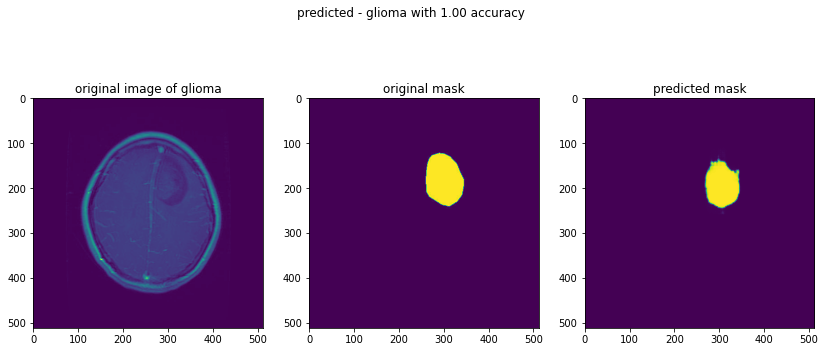

In [ ]:
prediction(scan_valgen1[10][0][0], model1, model2, mask_valgen1[10][0][0])

**Inference**
- We can observe that the model is segmenting the image and predicting it correctly.
- So, we can say that our model does reasonably good job

#Conclusion and Inferences 
- Classification based on simple models doesn't give good results 
- Using basic **AutoEncoder** we couldn't achieve the good Saliency map but we got good saliency map from UNET
architectures because of the skip connections they use to focus the region of interest i.e., tumor.
- We have used **Mean IOU** metric for segmentation because the tumor and non-tumor pixels are unbalanced.
- Addition of **three losses** (Binary cross-entropy, Focul loss, Dice Loss) gave much better result compared to using individual loss for segmentation.
- The model, **UNET with batch norm** and data augmentation gave the best result for the data.
- We used almost everything we have studied in this course for this project and we learned alot of field specific things. 


# Improvements and future plans
- **Improve the Classification:**  \
We can try improving the classification part by analysing the incorrect labeled images and working on the classification fine tuning more since we focused on the segmentation more here
- **Improve the shape preservation**: \
We can improve the segmentation part by trying to preserve that shape of the tumor more since we observed that in some images the shape of the image is not preserved much since it preserves the location of the tumor more
-**Transfer learning:** \
We can improve the transfer learning using the UNET from keras by training it for more epochs since the graph keeps improving 
- **Data augmentation:** \
We can try to use more new data and try to use more data augmentation so that we can use it for the real images by fine tuning this models


# References
- U-Net: Convolutional Networks for Biomedical Image Segmentation (Olaf Ronneberger, Philipp Fischer, Thomas Brox)(https://doi.org/10.48550/arXiv.1505.04597)
-  https://blog.paperspace.com/unet-architecture-image-segmentation/
- Loss Functions: https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-021-01431-y